In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `colab-token` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `colab-token`

### Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path_generated_images_MNIST = '/content/drive/MyDrive/8225/TP4_Projet/Generated_images_MNIST/first_pass_1_to_100/generated_image_'

In [ ]:
save_path_generated_images_wikiart = '/content/drive/MyDrive/8225/TP4_Projet/Generated_images_wikiart/generated_art_image_128_'

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm
from huggingface_hub import PyTorchModelHubMixin, hf_hub_download
import os, json
import kagglehub
from PIL import Image
from torch.utils.data import Subset
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

### Visualization function for generated images

In [ ]:
def save_image_grid(epoch: int, images: torch.Tensor, ncol: int, save_folder: str):
    image_grid = make_grid(images, ncol)     # Images in a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel last
    image_grid = image_grid.cpu().numpy()    # To Numpy
    image_grid = (image_grid + 1) / 2        # Rescale from [-1, 1] to [0, 1]

    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Epoch {epoch}')
    plt.savefig(f'{save_folder}{epoch:03d}.jpg')
    plt.close()

## MNIST

### MNIST dataset

In [ ]:
# batch size
batch_size = 64

# dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Mean 0.5, Std 0.5 → maps [0,1] to [-1,1]
])
dataset_MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset_MNIST, batch_size=batch_size, drop_last=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.14MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]


### Config

In [ ]:
# Configuration
epochs          = 200
batch_size      = 64
sample_size     = 100             # Number of random values to sample
image_dimension = 28              # MNIST images are 28x28
gen_lr          = 1.0e-4
dis_lr          = 1.0e-4
gen_layer_sizes = [256, 512, 1024]
dis_layer_sizes = [1024, 512, 256]

### Generator

In [ ]:
class Generator(nn.Module, PyTorchModelHubMixin):
    def __init__(self, sample_size: int, image_output_dimension: int, layer_sizes):
        super().__init__()

        # Random value vector size
        self.sample_size = sample_size

        self.image_output_dimension = image_output_dimension

        self.layer_sizes = layer_sizes

        # Layers
        previous_input_dim = sample_size
        layers = []
        for size in layer_sizes:
            layers += [nn.Linear(previous_input_dim, size), nn.LeakyReLU(0.1)]
            previous_input_dim = size

        self.layers = nn.Sequential(
            *layers,
            nn.Linear(previous_input_dim, image_output_dimension * image_output_dimension),
            nn.Tanh()
        )

    def forward(self, batch_size: int, z: torch.Tensor = None):
        """
        Forward method that either accepts a noise vector `z` or generates one internally if not provided.

        Args:
            batch_size (int): Number of samples to generate.
            z (torch.Tensor, optional): A noise tensor of shape (batch_size, sample_size). If None, it's generated.

        Returns:
            torch.Tensor: Generated images of shape (batch_size, 1, image_output_dimension, image_output_dimension)
        """
        if z is None:
            # generate random values
            z = torch.randn(batch_size, self.sample_size, device=next(self.parameters()).device)

        generated_images = self.layers(z).view(batch_size, 1, self.image_output_dimension, self.image_output_dimension)

        return generated_images

    def _save_pretrained(self, save_directory):

        os.makedirs(save_directory, exist_ok=True)

        config = {
            "sample_size": self.sample_size,
            "gen_layer_sizes": self.layer_sizes,
            "epochs": epochs,
            "batch_size": batch_size,
            "gen_lr": gen_lr,
            "dis_lr": dis_lr,
            "dis_layer_sizes": dis_layer_sizes,
            "image_dimension": self.image_output_dimension,
        }

        with open(os.path.join(save_directory, "config.json"), "w") as f:
            json.dump(config, f)

        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

    @classmethod
    def _from_pretrained(cls, model_id, revision, cache_dir, *model_args, **kwargs):
        # Device detection
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Download and read the config
        config_path = hf_hub_download(
            repo_id=model_id,
            filename="config.json",
            revision=revision,
            cache_dir=cache_dir
        )

        with open(config_path) as f:
            config = json.load(f)

        # Instantiate the model using the loaded config
        model = cls(
            sample_size=config["sample_size"],
            image_output_dimension=config["image_dimension"],
            layer_sizes=config["gen_layer_sizes"]
        )

        # Download the model weights
        weights_path = hf_hub_download(
            repo_id=model_id,
            filename="pytorch_model.bin",
            revision=revision,
            cache_dir=cache_dir
        )

        # Load weights and push to device
        model.load_state_dict(torch.load(weights_path, map_location=device))
        model.to(device)

        return model

### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_input_dimension: int, layer_sizes):
        super().__init__()

        self.image_input_dimension = image_input_dimension

        # Layers
        previous_input_dim = image_input_dimension * image_input_dimension
        layers = []
        for size in layer_sizes:
            layers += [nn.Linear(previous_input_dim, size), nn.LeakyReLU(0.2)]
            previous_input_dim = size

        self.layers = nn.Sequential(
            *layers,
            nn.Linear(previous_input_dim, 1)
        )

    def forward(self, x: torch.Tensor, targets: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass for the discriminator.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, image_dim, image_dim)
            targets (torch.Tensor, optional): Target labels for training with BCE loss.

        Returns:
            torch.Tensor: Discriminator output (logits) of shape (batch_size, 1)
        """
        # Flatten the image: (batch_size, 1, H, W) → (batch_size, H*W)
        x_flat = x.view(x.shape[0], -1)

        logit_predictions = self.layers(x_flat)

        if targets is not None:
            loss = F.binary_cross_entropy_with_logits(logit_predictions, targets)
            return loss

        return logit_predictions  # For inference or adversarial training

### Training loop

In [ ]:
# Instanciate models
generator = Generator(sample_size, image_dimension, gen_layer_sizes).to(device)
discriminator = Discriminator(image_dimension, dis_layer_sizes).to(device)

In [ ]:
# Optimizers - (https://github.com/soumith/ganhacks)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=gen_lr)
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=dis_lr)

In [ ]:
# Print training start
print(f'Training for {epochs} epochs is starting now.')

for epoch in range(epochs):
    dis_losses = []
    gen_losses = []

    for images, _ in tqdm(dataloader):
        images = images.to(device)

        # Label smoothing
        real_targets = torch.empty(batch_size, 1, device=device).uniform_(0.8, 1.0)  # Smooth real labels
        fake_targets = torch.zeros(batch_size, 1, device=device)                     # Fake labels (can also smooth)

        #===============================
        # Discriminator Training
        #===============================

        # Loss with MNIST image inputs and real_targets as labels
        discriminator.train()
        dis_loss = discriminator(images, real_targets)

        # Generate images in eval mode
        generator.eval()
        with torch.no_grad():
            generated_images = generator(batch_size)

        # Loss with generated image inputs and fake_targets as labels
        dis_loss += discriminator(generated_images, fake_targets)

        # Optimizer updates the discriminator parameters
        dis_optimizer.zero_grad()
        dis_loss.backward()
        dis_optimizer.step()

        #===============================
        # Generator Training
        #===============================

        # Generate images in train mode
        generator.train()
        generated_images = generator(batch_size)

        # Loss with generated image inputs and real_targets as labels
        discriminator.eval() # eval but we still need gradients
        gen_loss = discriminator(generated_images, real_targets)

        # Optimizer updates the generator parameters
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # Keep losses for logging
        dis_losses.append(dis_loss.item())
        gen_losses.append(gen_loss.item())

    # Print average losses
    print(f'Epoch: {epoch + 1}   Discriminator loss: {np.mean(dis_losses)}   Generator loss: {np.mean(gen_losses)}')


    # Save images
    if (epoch + 1) % 10 == 0 or epoch + 1 == 1:
        save_image_grid(
            epoch + 1,
            generator(batch_size),
            ncol=8,
            save_folder=save_path_generated_images_MNIST
            )

generator.push_to_hub("GAN-MNIST-generator")

Training for 200 epochs is starting now.


100%|██████████| 937/937 [00:16<00:00, 55.86it/s]


Epoch: 1   Discriminator loss: 0.5397902698501579   Generator loss: 4.0600400323419965


100%|██████████| 937/937 [00:16<00:00, 55.64it/s]


Epoch: 2   Discriminator loss: 0.6332027963029664   Generator loss: 3.9454309393909215


100%|██████████| 937/937 [00:16<00:00, 55.71it/s]


Epoch: 3   Discriminator loss: 0.6119787619551574   Generator loss: 3.3810144596700353


100%|██████████| 937/937 [00:16<00:00, 56.27it/s]


Epoch: 4   Discriminator loss: 0.43788070310396215   Generator loss: 4.803965475795872


100%|██████████| 937/937 [00:16<00:00, 56.16it/s]


Epoch: 5   Discriminator loss: 0.42157026419263005   Generator loss: 4.740652285746856


100%|██████████| 937/937 [00:16<00:00, 56.08it/s]


Epoch: 6   Discriminator loss: 0.4037093838543622   Generator loss: 5.456092309035767


100%|██████████| 937/937 [00:16<00:00, 55.87it/s]


Epoch: 7   Discriminator loss: 0.43547499749169405   Generator loss: 5.60047663746674


100%|██████████| 937/937 [00:16<00:00, 56.22it/s]


Epoch: 8   Discriminator loss: 0.40762549486078853   Generator loss: 5.5079044036193485


100%|██████████| 937/937 [00:16<00:00, 56.47it/s]


Epoch: 9   Discriminator loss: 0.4310939627497784   Generator loss: 5.372678932283579


100%|██████████| 937/937 [00:16<00:00, 55.77it/s]


Epoch: 10   Discriminator loss: 0.440878643265656   Generator loss: 5.106127979915704


100%|██████████| 937/937 [00:16<00:00, 55.88it/s]


Epoch: 11   Discriminator loss: 0.4666470148965414   Generator loss: 4.810718301266209


100%|██████████| 937/937 [00:16<00:00, 56.45it/s]


Epoch: 12   Discriminator loss: 0.46865892839660767   Generator loss: 4.735155991327292


100%|██████████| 937/937 [00:16<00:00, 55.89it/s]


Epoch: 13   Discriminator loss: 0.4758624409662367   Generator loss: 4.919291275415247


100%|██████████| 937/937 [00:16<00:00, 56.24it/s]


Epoch: 14   Discriminator loss: 0.4802714625379446   Generator loss: 4.879399071508182


100%|██████████| 937/937 [00:16<00:00, 56.10it/s]


Epoch: 15   Discriminator loss: 0.5192875744438986   Generator loss: 3.9998291854288435


100%|██████████| 937/937 [00:16<00:00, 56.33it/s]


Epoch: 16   Discriminator loss: 0.5634265415123967   Generator loss: 3.8447840290110293


100%|██████████| 937/937 [00:16<00:00, 56.45it/s]


Epoch: 17   Discriminator loss: 0.5954894211020006   Generator loss: 3.427671230844398


100%|██████████| 937/937 [00:16<00:00, 56.32it/s]


Epoch: 18   Discriminator loss: 0.6167350770187988   Generator loss: 3.4680907024009


100%|██████████| 937/937 [00:16<00:00, 55.96it/s]


Epoch: 19   Discriminator loss: 0.6263904491699874   Generator loss: 3.2228740998240646


100%|██████████| 937/937 [00:16<00:00, 56.04it/s]


Epoch: 20   Discriminator loss: 0.6367927294148961   Generator loss: 3.1392936416471273


100%|██████████| 937/937 [00:16<00:00, 56.28it/s]


Epoch: 21   Discriminator loss: 0.6810057111712632   Generator loss: 2.9087120481590834


100%|██████████| 937/937 [00:16<00:00, 56.51it/s]


Epoch: 22   Discriminator loss: 0.71252787797021   Generator loss: 2.6853505663072794


100%|██████████| 937/937 [00:16<00:00, 56.21it/s]


Epoch: 23   Discriminator loss: 0.7233156381828935   Generator loss: 2.631202067102414


100%|██████████| 937/937 [00:16<00:00, 56.35it/s]


Epoch: 24   Discriminator loss: 0.7253695422328269   Generator loss: 2.5144505203088294


100%|██████████| 937/937 [00:16<00:00, 56.15it/s]


Epoch: 25   Discriminator loss: 0.7623438455379123   Generator loss: 2.4230584389626535


100%|██████████| 937/937 [00:16<00:00, 56.07it/s]


Epoch: 26   Discriminator loss: 0.7810441566633186   Generator loss: 2.333033448604026


100%|██████████| 937/937 [00:16<00:00, 56.74it/s]


Epoch: 27   Discriminator loss: 0.806607878513499   Generator loss: 2.2045763106330862


100%|██████████| 937/937 [00:16<00:00, 55.84it/s]


Epoch: 28   Discriminator loss: 0.8299887978025536   Generator loss: 2.1216937242475367


100%|██████████| 937/937 [00:16<00:00, 56.52it/s]


Epoch: 29   Discriminator loss: 0.8312485020850231   Generator loss: 2.0354087631374185


100%|██████████| 937/937 [00:16<00:00, 56.24it/s]


Epoch: 30   Discriminator loss: 0.8559582197806115   Generator loss: 2.0479293911535943


100%|██████████| 937/937 [00:16<00:00, 56.39it/s]


Epoch: 31   Discriminator loss: 0.8612193387625948   Generator loss: 1.983631583199048


100%|██████████| 937/937 [00:16<00:00, 56.12it/s]


Epoch: 32   Discriminator loss: 0.8639622366924551   Generator loss: 1.9750572951906138


100%|██████████| 937/937 [00:16<00:00, 56.11it/s]


Epoch: 33   Discriminator loss: 0.8786414027722949   Generator loss: 1.905990108163787


100%|██████████| 937/937 [00:16<00:00, 56.52it/s]


Epoch: 34   Discriminator loss: 0.8820207926227036   Generator loss: 1.9064475416246576


100%|██████████| 937/937 [00:16<00:00, 56.17it/s]


Epoch: 35   Discriminator loss: 0.9094915246887166   Generator loss: 1.829041229495371


100%|██████████| 937/937 [00:16<00:00, 56.16it/s]


Epoch: 36   Discriminator loss: 0.9166081608168725   Generator loss: 1.7861682205215463


100%|██████████| 937/937 [00:16<00:00, 55.71it/s]


Epoch: 37   Discriminator loss: 0.9386226955956304   Generator loss: 1.7515567222425243


100%|██████████| 937/937 [00:16<00:00, 56.30it/s]


Epoch: 38   Discriminator loss: 0.9365536040023145   Generator loss: 1.7431627127760376


100%|██████████| 937/937 [00:16<00:00, 56.03it/s]


Epoch: 39   Discriminator loss: 0.9577595956679215   Generator loss: 1.668507544946009


100%|██████████| 937/937 [00:16<00:00, 56.35it/s]


Epoch: 40   Discriminator loss: 0.9569402338982647   Generator loss: 1.7090044450988893


100%|██████████| 937/937 [00:16<00:00, 56.05it/s]


Epoch: 41   Discriminator loss: 0.9605145906053459   Generator loss: 1.6738069787732819


100%|██████████| 937/937 [00:16<00:00, 55.94it/s]


Epoch: 42   Discriminator loss: 0.9821591760839953   Generator loss: 1.577842239890816


100%|██████████| 937/937 [00:16<00:00, 55.89it/s]


Epoch: 43   Discriminator loss: 0.9879631702266355   Generator loss: 1.6024885025579112


100%|██████████| 937/937 [00:16<00:00, 55.92it/s]


Epoch: 44   Discriminator loss: 0.9910464183752412   Generator loss: 1.5733886765695815


100%|██████████| 937/937 [00:16<00:00, 56.32it/s]


Epoch: 45   Discriminator loss: 1.000337235001388   Generator loss: 1.5582012139109689


100%|██████████| 937/937 [00:16<00:00, 55.86it/s]


Epoch: 46   Discriminator loss: 1.0072075947880619   Generator loss: 1.527233550680867


100%|██████████| 937/937 [00:16<00:00, 55.87it/s]


Epoch: 47   Discriminator loss: 1.0097923831598736   Generator loss: 1.5497754615042736


100%|██████████| 937/937 [00:16<00:00, 55.85it/s]


Epoch: 48   Discriminator loss: 1.016502126940032   Generator loss: 1.5251591081553106


100%|██████████| 937/937 [00:16<00:00, 55.99it/s]


Epoch: 49   Discriminator loss: 1.0199306367428351   Generator loss: 1.5009167362938822


100%|██████████| 937/937 [00:16<00:00, 56.29it/s]


Epoch: 50   Discriminator loss: 1.024462190229076   Generator loss: 1.4929943261558754


100%|██████████| 937/937 [00:16<00:00, 55.88it/s]


Epoch: 51   Discriminator loss: 1.034050184418323   Generator loss: 1.4788370344911084


100%|██████████| 937/937 [00:16<00:00, 56.40it/s]


Epoch: 52   Discriminator loss: 1.036963031284328   Generator loss: 1.4726045760808149


100%|██████████| 937/937 [00:16<00:00, 56.00it/s]


Epoch: 53   Discriminator loss: 1.0357254943954526   Generator loss: 1.4695483561259324


100%|██████████| 937/937 [00:16<00:00, 55.98it/s]


Epoch: 54   Discriminator loss: 1.0402264808768777   Generator loss: 1.4630684792804616


100%|██████████| 937/937 [00:16<00:00, 56.29it/s]


Epoch: 55   Discriminator loss: 1.0388752254503386   Generator loss: 1.458529544996223


100%|██████████| 937/937 [00:16<00:00, 56.38it/s]


Epoch: 56   Discriminator loss: 1.0510548850642707   Generator loss: 1.4265933778522617


100%|██████████| 937/937 [00:16<00:00, 55.86it/s]


Epoch: 57   Discriminator loss: 1.0522431175889428   Generator loss: 1.4242667961018827


100%|██████████| 937/937 [00:16<00:00, 56.20it/s]


Epoch: 58   Discriminator loss: 1.0595091038732416   Generator loss: 1.4245069642077133


100%|██████████| 937/937 [00:16<00:00, 56.26it/s]


Epoch: 59   Discriminator loss: 1.05492249815034   Generator loss: 1.4207638067013426


100%|██████████| 937/937 [00:16<00:00, 56.05it/s]


Epoch: 60   Discriminator loss: 1.057751456027097   Generator loss: 1.4178684573926692


100%|██████████| 937/937 [00:16<00:00, 55.98it/s]


Epoch: 61   Discriminator loss: 1.0640464965154675   Generator loss: 1.4071054911537129


100%|██████████| 937/937 [00:16<00:00, 55.89it/s]


Epoch: 62   Discriminator loss: 1.0641762837529056   Generator loss: 1.3946504370252757


100%|██████████| 937/937 [00:16<00:00, 56.33it/s]


Epoch: 63   Discriminator loss: 1.0718449954034934   Generator loss: 1.384948706168884


100%|██████████| 937/937 [00:16<00:00, 56.43it/s]


Epoch: 64   Discriminator loss: 1.0698987410315328   Generator loss: 1.3836377483803537


100%|██████████| 937/937 [00:16<00:00, 56.65it/s]


Epoch: 65   Discriminator loss: 1.072373030152621   Generator loss: 1.3967204680437721


100%|██████████| 937/937 [00:16<00:00, 56.22it/s]


Epoch: 66   Discriminator loss: 1.0768431689085294   Generator loss: 1.379641995358747


100%|██████████| 937/937 [00:16<00:00, 56.25it/s]


Epoch: 67   Discriminator loss: 1.076235099561441   Generator loss: 1.3603578316109413


100%|██████████| 937/937 [00:16<00:00, 56.13it/s]


Epoch: 68   Discriminator loss: 1.073498548285811   Generator loss: 1.3762986815217464


100%|██████████| 937/937 [00:16<00:00, 56.31it/s]


Epoch: 69   Discriminator loss: 1.079166695109808   Generator loss: 1.3661686721453672


100%|██████████| 937/937 [00:16<00:00, 55.88it/s]


Epoch: 70   Discriminator loss: 1.0798585127359266   Generator loss: 1.357600367310971


100%|██████████| 937/937 [00:16<00:00, 55.73it/s]


Epoch: 71   Discriminator loss: 1.0859816261391249   Generator loss: 1.349728558208543


100%|██████████| 937/937 [00:16<00:00, 55.36it/s]


Epoch: 72   Discriminator loss: 1.0907803013077921   Generator loss: 1.3392340482362688


100%|██████████| 937/937 [00:16<00:00, 55.86it/s]


Epoch: 73   Discriminator loss: 1.0898615838751085   Generator loss: 1.3378630716238358


100%|██████████| 937/937 [00:16<00:00, 56.00it/s]


Epoch: 74   Discriminator loss: 1.090350207867719   Generator loss: 1.3467193776413624


100%|██████████| 937/937 [00:16<00:00, 56.71it/s]


Epoch: 75   Discriminator loss: 1.0900553954703576   Generator loss: 1.3437498057919097


100%|██████████| 937/937 [00:16<00:00, 55.24it/s]


Epoch: 76   Discriminator loss: 1.0921461430786767   Generator loss: 1.3290016452047333


100%|██████████| 937/937 [00:16<00:00, 56.01it/s]


Epoch: 77   Discriminator loss: 1.096779058048285   Generator loss: 1.319385324560082


100%|██████████| 937/937 [00:16<00:00, 55.78it/s]


Epoch: 78   Discriminator loss: 1.0994047557531579   Generator loss: 1.3223005391363145


100%|██████████| 937/937 [00:16<00:00, 55.45it/s]


Epoch: 79   Discriminator loss: 1.1011006477166647   Generator loss: 1.314881838881982


100%|██████████| 937/937 [00:17<00:00, 55.08it/s]


Epoch: 80   Discriminator loss: 1.099697571045052   Generator loss: 1.307455694026601


100%|██████████| 937/937 [00:17<00:00, 54.27it/s]


Epoch: 81   Discriminator loss: 1.0976615501060811   Generator loss: 1.3342430603669573


100%|██████████| 937/937 [00:17<00:00, 55.07it/s]


Epoch: 82   Discriminator loss: 1.099129918863323   Generator loss: 1.3103029483664888


100%|██████████| 937/937 [00:16<00:00, 56.19it/s]


Epoch: 83   Discriminator loss: 1.1025983944392128   Generator loss: 1.3069461615897293


100%|██████████| 937/937 [00:16<00:00, 55.91it/s]


Epoch: 84   Discriminator loss: 1.0984529095245654   Generator loss: 1.3212356868904709


100%|██████████| 937/937 [00:16<00:00, 56.00it/s]


Epoch: 85   Discriminator loss: 1.09712614301938   Generator loss: 1.2979583617462802


100%|██████████| 937/937 [00:16<00:00, 56.27it/s]


Epoch: 86   Discriminator loss: 1.1009880956361744   Generator loss: 1.326432815292729


100%|██████████| 937/937 [00:16<00:00, 56.26it/s]


Epoch: 87   Discriminator loss: 1.1033338196376854   Generator loss: 1.2993749951349378


100%|██████████| 937/937 [00:16<00:00, 55.93it/s]


Epoch: 88   Discriminator loss: 1.1016362137702893   Generator loss: 1.3104191459357548


100%|██████████| 937/937 [00:16<00:00, 55.94it/s]


Epoch: 89   Discriminator loss: 1.1006945558011596   Generator loss: 1.3070743070595292


100%|██████████| 937/937 [00:16<00:00, 56.34it/s]


Epoch: 90   Discriminator loss: 1.1033203237975293   Generator loss: 1.3078738687005342


100%|██████████| 937/937 [00:16<00:00, 55.88it/s]


Epoch: 91   Discriminator loss: 1.097863610869665   Generator loss: 1.3249722831786124


100%|██████████| 937/937 [00:16<00:00, 56.01it/s]


Epoch: 92   Discriminator loss: 1.1041859499672815   Generator loss: 1.3067217814629717


100%|██████████| 937/937 [00:16<00:00, 56.26it/s]


Epoch: 93   Discriminator loss: 1.1071286863044079   Generator loss: 1.3103268579714071


100%|██████████| 937/937 [00:16<00:00, 55.80it/s]


Epoch: 94   Discriminator loss: 1.0985176778908345   Generator loss: 1.3144772404540437


100%|██████████| 937/937 [00:16<00:00, 56.40it/s]


Epoch: 95   Discriminator loss: 1.1027130298197205   Generator loss: 1.3163124337522045


100%|██████████| 937/937 [00:16<00:00, 56.24it/s]


Epoch: 96   Discriminator loss: 1.1037474609235562   Generator loss: 1.2989643270839621


100%|██████████| 937/937 [00:16<00:00, 56.13it/s]


Epoch: 97   Discriminator loss: 1.0974498561632162   Generator loss: 1.3201301424836653


100%|██████████| 937/937 [00:16<00:00, 55.27it/s]


Epoch: 98   Discriminator loss: 1.1005805523443883   Generator loss: 1.3214606734960794


100%|██████████| 937/937 [00:17<00:00, 55.04it/s]


Epoch: 99   Discriminator loss: 1.1003923777455071   Generator loss: 1.3151721097489177


100%|██████████| 937/937 [00:16<00:00, 55.34it/s]


Epoch: 100   Discriminator loss: 1.0998121168595623   Generator loss: 1.3183265889467017


100%|██████████| 937/937 [00:16<00:00, 56.10it/s]


Epoch: 101   Discriminator loss: 1.0977421695547398   Generator loss: 1.3123245963800934


100%|██████████| 937/937 [00:17<00:00, 54.88it/s]


Epoch: 102   Discriminator loss: 1.0991028330369337   Generator loss: 1.3089128056483437


100%|██████████| 937/937 [00:17<00:00, 55.01it/s]


Epoch: 103   Discriminator loss: 1.0994779299646458   Generator loss: 1.3111269210038852


100%|██████████| 937/937 [00:16<00:00, 55.86it/s]


Epoch: 104   Discriminator loss: 1.0969078470828566   Generator loss: 1.3248730698161089


100%|██████████| 937/937 [00:16<00:00, 55.54it/s]


Epoch: 105   Discriminator loss: 1.092607997079542   Generator loss: 1.3184785496845062


100%|██████████| 937/937 [00:16<00:00, 56.17it/s]


Epoch: 106   Discriminator loss: 1.0934366571101715   Generator loss: 1.3339025427844762


100%|██████████| 937/937 [00:16<00:00, 56.00it/s]


Epoch: 107   Discriminator loss: 1.098471077936309   Generator loss: 1.3210529486550338


100%|██████████| 937/937 [00:16<00:00, 56.05it/s]


Epoch: 108   Discriminator loss: 1.0987763156122434   Generator loss: 1.310428719255942


100%|██████████| 937/937 [00:16<00:00, 55.86it/s]


Epoch: 109   Discriminator loss: 1.0949810997780767   Generator loss: 1.3249005506107367


100%|██████████| 937/937 [00:16<00:00, 56.21it/s]


Epoch: 110   Discriminator loss: 1.0936066442772572   Generator loss: 1.3351311043079788


100%|██████████| 937/937 [00:16<00:00, 55.55it/s]


Epoch: 111   Discriminator loss: 1.0964152054064047   Generator loss: 1.3182474806698052


100%|██████████| 937/937 [00:16<00:00, 56.14it/s]


Epoch: 112   Discriminator loss: 1.0917131063650614   Generator loss: 1.3370971137711434


100%|██████████| 937/937 [00:16<00:00, 55.54it/s]


Epoch: 113   Discriminator loss: 1.0927613784053156   Generator loss: 1.3374872100136959


100%|██████████| 937/937 [00:16<00:00, 55.17it/s]


Epoch: 114   Discriminator loss: 1.0867672476086572   Generator loss: 1.3439046987983434


100%|██████████| 937/937 [00:16<00:00, 56.20it/s]


Epoch: 115   Discriminator loss: 1.0951609817614805   Generator loss: 1.3309142116294217


100%|██████████| 937/937 [00:16<00:00, 56.09it/s]


Epoch: 116   Discriminator loss: 1.0865975339740928   Generator loss: 1.3511095088345009


100%|██████████| 937/937 [00:16<00:00, 55.29it/s]


Epoch: 117   Discriminator loss: 1.086930117395924   Generator loss: 1.3564691695612294


100%|██████████| 937/937 [00:16<00:00, 56.05it/s]


Epoch: 118   Discriminator loss: 1.0921430661558724   Generator loss: 1.3366344908894445


100%|██████████| 937/937 [00:16<00:00, 55.84it/s]


Epoch: 119   Discriminator loss: 1.0876509273064938   Generator loss: 1.350152352894383


100%|██████████| 937/937 [00:16<00:00, 55.61it/s]


Epoch: 120   Discriminator loss: 1.0882920454889378   Generator loss: 1.344162005306944


100%|██████████| 937/937 [00:16<00:00, 56.37it/s]


Epoch: 121   Discriminator loss: 1.0867377034246348   Generator loss: 1.3494313146159642


100%|██████████| 937/937 [00:16<00:00, 56.17it/s]


Epoch: 122   Discriminator loss: 1.089761750293516   Generator loss: 1.335877228381158


100%|██████████| 937/937 [00:16<00:00, 55.75it/s]


Epoch: 123   Discriminator loss: 1.086649938861232   Generator loss: 1.344980934259095


100%|██████████| 937/937 [00:16<00:00, 55.67it/s]


Epoch: 124   Discriminator loss: 1.0885765218556627   Generator loss: 1.3460196786527319


100%|██████████| 937/937 [00:16<00:00, 55.58it/s]


Epoch: 125   Discriminator loss: 1.0835192912161795   Generator loss: 1.347442794126024


100%|██████████| 937/937 [00:16<00:00, 55.41it/s]


Epoch: 126   Discriminator loss: 1.0807483050586575   Generator loss: 1.3598370067337915


100%|██████████| 937/937 [00:16<00:00, 55.93it/s]


Epoch: 127   Discriminator loss: 1.0780763055497071   Generator loss: 1.361831574646106


100%|██████████| 937/937 [00:16<00:00, 56.14it/s]


Epoch: 128   Discriminator loss: 1.0774158229822792   Generator loss: 1.3702252630617473


100%|██████████| 937/937 [00:16<00:00, 55.98it/s]


Epoch: 129   Discriminator loss: 1.081782524461044   Generator loss: 1.3704451059837097


100%|██████████| 937/937 [00:16<00:00, 55.94it/s]


Epoch: 130   Discriminator loss: 1.0765009198651878   Generator loss: 1.3798767422408407


100%|██████████| 937/937 [00:16<00:00, 55.30it/s]


Epoch: 131   Discriminator loss: 1.0800352485864368   Generator loss: 1.3613546177061033


100%|██████████| 937/937 [00:16<00:00, 55.57it/s]


Epoch: 132   Discriminator loss: 1.0722739936956855   Generator loss: 1.38276477722628


100%|██████████| 937/937 [00:16<00:00, 56.30it/s]


Epoch: 133   Discriminator loss: 1.0824012538157761   Generator loss: 1.3720358418680434


100%|██████████| 937/937 [00:16<00:00, 56.36it/s]


Epoch: 134   Discriminator loss: 1.0825542450714518   Generator loss: 1.3638659937659094


100%|██████████| 937/937 [00:16<00:00, 56.24it/s]


Epoch: 135   Discriminator loss: 1.0790880200957031   Generator loss: 1.3730712493557558


100%|██████████| 937/937 [00:16<00:00, 55.69it/s]


Epoch: 136   Discriminator loss: 1.0763878576783512   Generator loss: 1.3798563005193956


100%|██████████| 937/937 [00:16<00:00, 55.58it/s]


Epoch: 137   Discriminator loss: 1.0861648754987034   Generator loss: 1.3603050656608737


100%|██████████| 937/937 [00:16<00:00, 55.91it/s]


Epoch: 138   Discriminator loss: 1.0867364279361265   Generator loss: 1.3566704421058664


100%|██████████| 937/937 [00:16<00:00, 55.96it/s]


Epoch: 139   Discriminator loss: 1.0895693553422787   Generator loss: 1.3529308544533485


100%|██████████| 937/937 [00:16<00:00, 55.74it/s]


Epoch: 140   Discriminator loss: 1.0797627355144017   Generator loss: 1.3679140144631092


100%|██████████| 937/937 [00:16<00:00, 56.14it/s]


Epoch: 141   Discriminator loss: 1.081501300904896   Generator loss: 1.3672641718018652


100%|██████████| 937/937 [00:16<00:00, 55.96it/s]


Epoch: 142   Discriminator loss: 1.0755024252095624   Generator loss: 1.3747909990166143


100%|██████████| 937/937 [00:16<00:00, 56.03it/s]


Epoch: 143   Discriminator loss: 1.078805311003515   Generator loss: 1.371391167890046


100%|██████████| 937/937 [00:16<00:00, 55.94it/s]


Epoch: 144   Discriminator loss: 1.0760609864425252   Generator loss: 1.379238429611495


100%|██████████| 937/937 [00:16<00:00, 55.77it/s]


Epoch: 145   Discriminator loss: 1.0837602119181173   Generator loss: 1.361052381127214


100%|██████████| 937/937 [00:16<00:00, 55.56it/s]


Epoch: 146   Discriminator loss: 1.07149079076254   Generator loss: 1.3795883682265226


100%|██████████| 937/937 [00:16<00:00, 55.99it/s]


Epoch: 147   Discriminator loss: 1.0716395581035756   Generator loss: 1.3842434743170804


100%|██████████| 937/937 [00:16<00:00, 55.74it/s]


Epoch: 148   Discriminator loss: 1.0697519277304952   Generator loss: 1.3898256419180806


100%|██████████| 937/937 [00:16<00:00, 55.64it/s]


Epoch: 149   Discriminator loss: 1.071069203356923   Generator loss: 1.3831419794002235


100%|██████████| 937/937 [00:16<00:00, 55.84it/s]


Epoch: 150   Discriminator loss: 1.0687053839068785   Generator loss: 1.392911001928588


100%|██████████| 937/937 [00:16<00:00, 56.07it/s]


Epoch: 151   Discriminator loss: 1.0685624960519715   Generator loss: 1.3881749414710631


100%|██████████| 937/937 [00:16<00:00, 55.65it/s]


Epoch: 152   Discriminator loss: 1.0632348224091301   Generator loss: 1.3931167939938247


100%|██████████| 937/937 [00:16<00:00, 56.10it/s]


Epoch: 153   Discriminator loss: 1.0636917415652485   Generator loss: 1.3990698405238327


100%|██████████| 937/937 [00:16<00:00, 55.47it/s]


Epoch: 154   Discriminator loss: 1.0684657289607802   Generator loss: 1.394209261128844


100%|██████████| 937/937 [00:16<00:00, 56.12it/s]


Epoch: 155   Discriminator loss: 1.0573649474498175   Generator loss: 1.4112334316288266


100%|██████████| 937/937 [00:16<00:00, 56.44it/s]


Epoch: 156   Discriminator loss: 1.0670304934523023   Generator loss: 1.4003261355096783


100%|██████████| 937/937 [00:16<00:00, 56.26it/s]


Epoch: 157   Discriminator loss: 1.0603377072890006   Generator loss: 1.401211805760924


100%|██████████| 937/937 [00:16<00:00, 56.35it/s]


Epoch: 158   Discriminator loss: 1.0598486933535165   Generator loss: 1.4082549482806643


100%|██████████| 937/937 [00:16<00:00, 56.11it/s]


Epoch: 159   Discriminator loss: 1.0548800707753974   Generator loss: 1.4239552314278918


100%|██████████| 937/937 [00:16<00:00, 56.36it/s]


Epoch: 160   Discriminator loss: 1.057536823263545   Generator loss: 1.415763256262308


100%|██████████| 937/937 [00:16<00:00, 55.77it/s]


Epoch: 161   Discriminator loss: 1.0566368899452268   Generator loss: 1.4093278959441211


100%|██████████| 937/937 [00:16<00:00, 55.90it/s]


Epoch: 162   Discriminator loss: 1.0505534562509877   Generator loss: 1.4285742024092944


100%|██████████| 937/937 [00:16<00:00, 55.63it/s]


Epoch: 163   Discriminator loss: 1.0487861446916993   Generator loss: 1.4275318447782746


100%|██████████| 937/937 [00:16<00:00, 55.57it/s]


Epoch: 164   Discriminator loss: 1.0539204183103181   Generator loss: 1.4168263267300298


100%|██████████| 937/937 [00:16<00:00, 56.44it/s]


Epoch: 165   Discriminator loss: 1.0485695959282533   Generator loss: 1.4345570956630158


100%|██████████| 937/937 [00:16<00:00, 56.21it/s]


Epoch: 166   Discriminator loss: 1.0437757047161602   Generator loss: 1.428100754255419


100%|██████████| 937/937 [00:16<00:00, 56.16it/s]


Epoch: 167   Discriminator loss: 1.042229725940505   Generator loss: 1.439268902119094


100%|██████████| 937/937 [00:16<00:00, 56.04it/s]


Epoch: 168   Discriminator loss: 1.0341095723362845   Generator loss: 1.4565364995150327


100%|██████████| 937/937 [00:16<00:00, 55.98it/s]


Epoch: 169   Discriminator loss: 1.037581242772024   Generator loss: 1.4542187463766483


100%|██████████| 937/937 [00:16<00:00, 56.00it/s]


Epoch: 170   Discriminator loss: 1.0436147418322406   Generator loss: 1.4507557153701782


100%|██████████| 937/937 [00:16<00:00, 56.28it/s]


Epoch: 171   Discriminator loss: 1.0406094328952573   Generator loss: 1.4508769673751538


100%|██████████| 937/937 [00:16<00:00, 55.82it/s]


Epoch: 172   Discriminator loss: 1.0357981090739035   Generator loss: 1.4538345581184966


100%|██████████| 937/937 [00:16<00:00, 55.26it/s]


Epoch: 173   Discriminator loss: 1.0356584468671581   Generator loss: 1.4633844700923215


100%|██████████| 937/937 [00:16<00:00, 55.73it/s]


Epoch: 174   Discriminator loss: 1.0371826471742978   Generator loss: 1.4538588358472988


100%|██████████| 937/937 [00:16<00:00, 56.04it/s]


Epoch: 175   Discriminator loss: 1.0292876507836446   Generator loss: 1.4653142908212342


100%|██████████| 937/937 [00:16<00:00, 55.81it/s]


Epoch: 176   Discriminator loss: 1.0232166836203227   Generator loss: 1.466674448141039


100%|██████████| 937/937 [00:16<00:00, 55.19it/s]


Epoch: 177   Discriminator loss: 1.0257556051683783   Generator loss: 1.4760723553574073


100%|██████████| 937/937 [00:16<00:00, 55.44it/s]


Epoch: 178   Discriminator loss: 1.0216812404268198   Generator loss: 1.4845520580463756


100%|██████████| 937/937 [00:16<00:00, 55.40it/s]


Epoch: 179   Discriminator loss: 1.0172170670335294   Generator loss: 1.4920201814289153


100%|██████████| 937/937 [00:16<00:00, 55.96it/s]


Epoch: 180   Discriminator loss: 1.0198949304436162   Generator loss: 1.5087152080194928


100%|██████████| 937/937 [00:16<00:00, 55.90it/s]


Epoch: 181   Discriminator loss: 1.017631265117112   Generator loss: 1.5038194205997593


100%|██████████| 937/937 [00:16<00:00, 55.71it/s]


Epoch: 182   Discriminator loss: 1.015510394517233   Generator loss: 1.502355061829281


100%|██████████| 937/937 [00:16<00:00, 55.73it/s]


Epoch: 183   Discriminator loss: 1.0133314656218952   Generator loss: 1.5056041692847757


100%|██████████| 937/937 [00:16<00:00, 55.27it/s]


Epoch: 184   Discriminator loss: 1.0090365375500479   Generator loss: 1.5190726986816878


100%|██████████| 937/937 [00:16<00:00, 55.63it/s]


Epoch: 185   Discriminator loss: 1.0122390661066598   Generator loss: 1.5232174313819014


100%|██████████| 937/937 [00:16<00:00, 55.93it/s]


Epoch: 186   Discriminator loss: 1.0056453581935187   Generator loss: 1.5226280764301914


100%|██████████| 937/937 [00:16<00:00, 55.57it/s]


Epoch: 187   Discriminator loss: 1.0044695755969753   Generator loss: 1.5374237005077025


100%|██████████| 937/937 [00:16<00:00, 55.61it/s]


Epoch: 188   Discriminator loss: 1.0073328784079536   Generator loss: 1.5391177567499297


100%|██████████| 937/937 [00:16<00:00, 55.61it/s]


Epoch: 189   Discriminator loss: 1.0050025649106362   Generator loss: 1.5360087218635747


100%|██████████| 937/937 [00:17<00:00, 54.99it/s]


Epoch: 190   Discriminator loss: 1.0027269539736379   Generator loss: 1.5408583671458884


100%|██████████| 937/937 [00:16<00:00, 55.82it/s]


Epoch: 191   Discriminator loss: 0.9991404316214131   Generator loss: 1.557015215447262


100%|██████████| 937/937 [00:16<00:00, 55.54it/s]


Epoch: 192   Discriminator loss: 0.9999398846127562   Generator loss: 1.550972784214366


100%|██████████| 937/937 [00:16<00:00, 55.64it/s]


Epoch: 193   Discriminator loss: 0.999860416608788   Generator loss: 1.545102291135167


100%|██████████| 937/937 [00:16<00:00, 55.63it/s]


Epoch: 194   Discriminator loss: 0.9954174579525706   Generator loss: 1.5519427087798063


100%|██████████| 937/937 [00:16<00:00, 55.32it/s]


Epoch: 195   Discriminator loss: 0.9953189254315966   Generator loss: 1.5685702292616366


100%|██████████| 937/937 [00:16<00:00, 55.24it/s]


Epoch: 196   Discriminator loss: 0.9916210629387879   Generator loss: 1.5672400992606212


100%|██████████| 937/937 [00:17<00:00, 54.40it/s]


Epoch: 197   Discriminator loss: 0.9946753051899286   Generator loss: 1.5655764939309185


100%|██████████| 937/937 [00:16<00:00, 55.96it/s]


Epoch: 198   Discriminator loss: 0.9871636158374228   Generator loss: 1.583012023374136


100%|██████████| 937/937 [00:16<00:00, 55.90it/s]


Epoch: 199   Discriminator loss: 0.9897068884609349   Generator loss: 1.5795756546639328


100%|██████████| 937/937 [00:16<00:00, 55.80it/s]


Epoch: 200   Discriminator loss: 0.9879855859623139   Generator loss: 1.5841261228604149


pytorch_model.bin:   0%|          | 0.00/5.95M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bASILgIL/GAN-MNIST-generator/commit/51ea59dff7d1d37afb5ced120cd21cea7fb8e0dc', commit_message='Push model using huggingface_hub.', commit_description='', oid='51ea59dff7d1d37afb5ced120cd21cea7fb8e0dc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bASILgIL/GAN-MNIST-generator', endpoint='https://huggingface.co', repo_type='model', repo_id='bASILgIL/GAN-MNIST-generator'), pr_revision=None, pr_num=None)

### Image generation

In [ ]:
batch_size = 64

In [ ]:
gan_mnist_generator = Generator.from_pretrained("bASILgIL/GAN-MNIST-generator")

In [ ]:
save_image_grid(
            69,
            gan_mnist_generator(batch_size),
            ncol=8,
            save_folder='/content/drive/MyDrive/8225/TP4_Projet/Generated_images_MNIST/gan_mnist_generated_image_'
            )

## WikiArt

### Upload WikiArt dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("steubk/wikiart")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/wikiart


In [ ]:
save_path_generated_images_wikiart = '/content/drive/MyDrive/8225/TP4_Projet/Generated_images_wikiart/test_image_'
wikiart_dataset_path = '/kaggle/input/wikiart'

### Configs

In [ ]:
# Training parameters - 3x64x64 - 100epochs
epochs = 100
batch_size = 64
sample_size = 100
image_dimension = 64  # For 64x64 images
image_channels = 3    # RGB
gen_lr = 2e-4
dis_lr = 2e-4
gen_layer_sizes = [1024, 2048, 4096]
dis_layer_sizes = [4096, 1024]

In [ ]:
# Training parameters - 3x128x128 - 10 epochs
epochs = 10
batch_size = 64
sample_size = 100
image_dimension = 128  # For 128x128 images
image_channels = 3    # RGB
gen_lr = 2e-4
dis_lr = 2e-4
gen_layer_sizes = [1024, 2048, 4096]
dis_layer_sizes = [4096, 1024]

In [ ]:
# Training parameters - 3x128x128 - 100 epochs
epochs = 100
batch_size = 64
sample_size = 100
image_dimension = 128  # For 128x128 images
image_channels = 3    # RGB
gen_lr = 2e-4
dis_lr = 2e-4
gen_layer_sizes = [1024, 2048, 4096]
dis_layer_sizes = [4096, 1024]

In [ ]:
# TODO: try this config
# Training parameters - 3x64x64 images
epochs = 1000                  # More epochs to compensate for small dataset
batch_size = 32                # Smaller batch = more updates per epoch = better generalization
sample_size = 100              # Noise vector (z), typical choice
image_dimension = 64           # For 64x64 images
image_channels = 3             # RGB

gen_lr = 2e-4                  # Good default for Adam
dis_lr = 2e-4                  # Same here

# Fully connected layer sizes
# 64x64 RGB image = 3 x 64 x 64 = 12288
gen_layer_sizes = [512, 1024, 2048]    # z=100 → 512 → 1024 → 2048 → 12288 → reshape (3, 64, 64)
dis_layer_sizes = [2048, 512]          # 12288 → 2048 → 512 → 1 (logit)

### Preprocess

In [ ]:
# crop to square on minimum image dimension then resize
# 64 by 64 images
class CenterCropMinSide:
    def __call__(self, img: Image.Image):
        min_dim = min(img.size)
        return transforms.functional.center_crop(img, min_dim)

transform_wikiart = transforms.Compose([
    CenterCropMinSide(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

In [ ]:
# Crop to square on minimum image dimension then resize
# 128 by 128 images
class CenterCropMinSide:
    def __call__(self, img: Image.Image):
        min_dim = min(img.size)
        return transforms.functional.center_crop(img, min_dim)

transform_wikiart = transforms.Compose([
    CenterCropMinSide(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

### Dataset & Dataloaders

In [ ]:
# Full Dataset
dataset_wikiart = datasets.ImageFolder(root=wikiart_dataset_path, transform=transform_wikiart)

In [ ]:
# Art movements in Dataset
print("All genres in dataset:")
for idx, genre in enumerate(dataset_wikiart.classes):
    print(f"{idx}: {genre}")

All genres in dataset:
0: Abstract_Expressionism
1: Action_painting
2: Analytical_Cubism
3: Art_Nouveau_Modern
4: Baroque
5: Color_Field_Painting
6: Contemporary_Realism
7: Cubism
8: Early_Renaissance
9: Expressionism
10: Fauvism
11: High_Renaissance
12: Impressionism
13: Mannerism_Late_Renaissance
14: Minimalism
15: Naive_Art_Primitivism
16: New_Realism
17: Northern_Renaissance
18: Pointillism
19: Pop_Art
20: Post_Impressionism
21: Realism
22: Rococo
23: Romanticism
24: Symbolism
25: Synthetic_Cubism
26: Ukiyo_e


In [ ]:
# Dataloader with full dataset
dataloader = DataLoader(dataset_wikiart, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [ ]:
# Dataloader with random selection of 8000 samples from the dataset
nb_samples = 8000
indices = random.sample(range(len(dataset_wikiart)), nb_samples)
subset_dataset = Subset(dataset_wikiart, indices)
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [ ]:
# Art movements chosen
allowed_genres = ["Ukiyo_e"]

# Map folder names to class indices
genre_to_index = {genre: idx for idx, genre in enumerate(dataset_wikiart.classes)}

# Get indices of classes wanted
allowed_indices = [genre_to_index[g] for g in allowed_genres]

# Get indices of samples in dataset that match allowed classes
selected_indices = [i for i, (_, label) in enumerate(dataset_wikiart.samples) if label in allowed_indices]

# Create a subset
selected_art_movements_dataset = Subset(dataset_wikiart, selected_indices)

# Use subset in dataloader
dataloader = DataLoader(selected_art_movements_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)


### Visualization of a random selection of the dataset

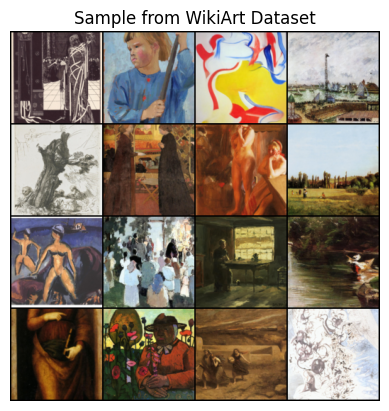

In [ ]:
# Grab one batch
images, labels = next(iter(dataloader))

# Rescale from [-1, 1] to [0, 1]
images = (images * 0.5) + 0.5

# Create a grid
grid = make_grid(images[:16], nrow=4)  # First 16 images, 4x4

# Convert to numpy for plotting
np_grid = grid.permute(1, 2, 0).numpy()

# Plot
plt.imshow(np_grid)
plt.axis('off')
plt.title("Sample from WikiArt Dataset")
plt.show()

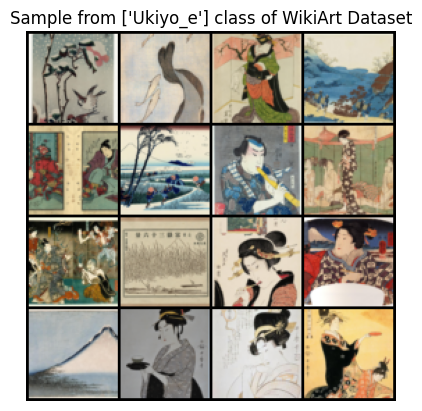

In [ ]:
# Selected art movements dataset
images, labels = next(iter(dataloader))

# Rescale from [-1, 1] to [0, 1]
images = (images * 0.5) + 0.5

# Create a grid
grid = make_grid(images[:16], nrow=4)  # First 16 images, 4x4

# Convert to numpy for plotting
np_grid = grid.permute(1, 2, 0).numpy()

# Plot
plt.imshow(np_grid)
plt.axis('off')
plt.title(f"Sample from {allowed_genres} class of WikiArt Dataset")
plt.show()

### RGB Generator

In [ ]:
class Generator_RGB(nn.Module, PyTorchModelHubMixin):
    def __init__(self, sample_size: int, image_output_dimension: int, layer_sizes):
        super().__init__()
        self.sample_size = sample_size
        self.image_output_dimension = image_output_dimension
        self.layer_sizes = layer_sizes

        previous_input_dim = sample_size
        layers = []
        for size in layer_sizes:
            layers += [nn.Linear(previous_input_dim, size), nn.LeakyReLU(0.1)]
            previous_input_dim = size

        # Updated: RGB output = 3 channels
        final_output_dim = image_output_dimension * image_output_dimension * 3

        self.layers = nn.Sequential(
            *layers,
            nn.Linear(previous_input_dim, final_output_dim),
            nn.Tanh()
        )

    def forward(self, batch_size: int, z: torch.Tensor = None):
        if z is None:
            z = torch.randn(batch_size, self.sample_size, device=next(self.parameters()).device)

        generated = self.layers(z)
        generated = generated.view(batch_size, 3, self.image_output_dimension, self.image_output_dimension)
        return generated

    def _save_pretrained(self, save_directory):
        os.makedirs(save_directory, exist_ok=True)

        # Save config
        config = {
            "sample_size": self.sample_size,
            "gen_layer_sizes": self.layer_sizes,
            "epochs": epochs,
            "batch_size": batch_size,
            "gen_lr": gen_lr,
            "dis_lr": dis_lr,
            "dis_layer_sizes": dis_layer_sizes,
            "image_dimension": self.image_output_dimension,
            "num_channels": 3
        }

        with open(os.path.join(save_directory, "config.json"), "w") as f:
            json.dump(config, f)

        # Save model weights
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

    @classmethod
    def _from_pretrained(cls, model_id, revision, cache_dir, *model_args, **kwargs):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load config
        config_path = hf_hub_download(
            repo_id=model_id,
            filename="config.json",
            revision=revision,
            cache_dir=cache_dir
        )

        with open(config_path) as f:
            config = json.load(f)

        # Instantiate the model
        model = cls(
            sample_size=config["sample_size"],
            image_output_dimension=config["image_dimension"],
            layer_sizes=config["gen_layer_sizes"]
        )

        # Load weights
        weights_path = hf_hub_download(
            repo_id=model_id,
            filename="pytorch_model.bin",
            revision=revision,
            cache_dir=cache_dir
        )

        model.load_state_dict(torch.load(weights_path, map_location=device))
        model.to(device)

        return model

In [ ]:
# TODO: closer to original so try with this
class Generator_RGB(nn.Module, PyTorchModelHubMixin):
    def __init__(self, sample_size: int, image_output_dimension: int, layer_sizes):
        super().__init__()
        self.sample_size = sample_size
        self.image_output_dimension = image_output_dimension
        self.layer_sizes = layer_sizes

        previous_input_dim = sample_size
        layers = []
        for size in layer_sizes:
            layers += [nn.Linear(previous_input_dim, size), nn.ReLU()]
            previous_input_dim = size

        # Updated: RGB output = 3 channels
        final_output_dim = image_output_dimension * image_output_dimension * 3

        self.layers = nn.Sequential(
            *layers,
            nn.Linear(previous_input_dim, final_output_dim),
            nn.Tanh()
        )

    def forward(self, batch_size: int, z: torch.Tensor = None):
        if z is None:
            z = torch.randn(batch_size, self.sample_size, device=next(self.parameters()).device)

        generated = self.layers(z)
        generated = generated.view(batch_size, 3, self.image_output_dimension, self.image_output_dimension)
        return generated

    def _save_pretrained(self, save_directory):
        os.makedirs(save_directory, exist_ok=True)

        # Save config
        config = {
            "sample_size": self.sample_size,
            "gen_layer_sizes": self.layer_sizes,
            "epochs": epochs,
            "batch_size": batch_size,
            "gen_lr": gen_lr,
            "dis_lr": dis_lr,
            "dis_layer_sizes": dis_layer_sizes,
            "image_dimension": self.image_output_dimension,
            "num_channels": 3
        }

        with open(os.path.join(save_directory, "config.json"), "w") as f:
            json.dump(config, f)

        # Save model weights
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

    @classmethod
    def _from_pretrained(cls, model_id, revision, cache_dir, *model_args, **kwargs):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load config
        config_path = hf_hub_download(
            repo_id=model_id,
            filename="config.json",
            revision=revision,
            cache_dir=cache_dir
        )

        with open(config_path) as f:
            config = json.load(f)

        # Instantiate the model
        model = cls(
            sample_size=config["sample_size"],
            image_output_dimension=config["image_dimension"],
            layer_sizes=config["gen_layer_sizes"]
        )

        # Load weights
        weights_path = hf_hub_download(
            repo_id=model_id,
            filename="pytorch_model.bin",
            revision=revision,
            cache_dir=cache_dir
        )

        model.load_state_dict(torch.load(weights_path, map_location=device))
        model.to(device)

        return model

### RGB Discriminator

In [ ]:
class Discriminator_RGB(nn.Module):
    def __init__(self, image_input_dimension: int, layer_sizes):
        super().__init__()
        self.image_input_dimension = image_input_dimension

        previous_input_dim = image_input_dimension * image_input_dimension * 3
        layers = []
        for size in layer_sizes:
            layers += [nn.Linear(previous_input_dim, size), nn.LeakyReLU(0.2)]
            previous_input_dim = size

        self.layers = nn.Sequential(
            *layers,
            nn.Linear(previous_input_dim, 1)
        )

    def forward(self, x: torch.Tensor, targets: torch.Tensor = None) -> torch.Tensor:
        x_flat = x.view(x.shape[0], -1)
        logit_predictions = self.layers(x_flat)
        if targets is not None:
            return F.binary_cross_entropy_with_logits(logit_predictions, targets)
        return logit_predictions

In [ ]:
# TODO: closer to original so try with this
class Discriminator_RGB(nn.Module):
    def __init__(self, image_input_dimension: int, layer_sizes):
        super().__init__()
        self.image_input_dimension = image_input_dimension

        previous_input_dim = image_input_dimension * image_input_dimension * 3
        layers = []
        for size in layer_sizes:
            layers += [nn.Linear(previous_input_dim, size), nn.ReLU()]
            previous_input_dim = size

        self.layers = nn.Sequential(
            *layers,
            nn.Linear(previous_input_dim, 1)
        )

    def forward(self, x: torch.Tensor, targets: torch.Tensor = None) -> torch.Tensor:
        x_flat = x.view(x.shape[0], -1)
        logit_predictions = self.layers(x_flat)
        if targets is not None:
            return F.binary_cross_entropy_with_logits(logit_predictions, targets)
        return logit_predictions

### Training loop

In [ ]:
# Instantiate model
generator = Generator_RGB(sample_size, image_dimension, gen_layer_sizes).to(device)
discriminator = Discriminator_RGB(image_dimension, dis_layer_sizes).to(device)

NameError: name 'sample_size' is not defined

In [ ]:
# Optimizers
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=dis_lr, betas=(0.5, 0.999))

#### 100 epochs on 8000 samples with 3x64x64 images

In [ ]:
print(f"Training on {len(dataloader.dataset)} images for {epochs} epochs")

fixed_z = torch.randn(batch_size, sample_size, device=device)

for epoch in range(epochs):
    dis_losses = []
    gen_losses = []

    for images, _ in tqdm(dataloader):
        assert images.shape[1] == 3, "Not RGB!"
        images = images.to(device, non_blocking=True)

        # Label smoothing
        real_targets = torch.empty(batch_size, 1, device=device).uniform_(0.8, 1.0)
        fake_targets = torch.zeros(batch_size, 1, device=device)

        # ========================
        # Discriminator Training
        # ========================
        discriminator.train()
        dis_loss = discriminator(images, real_targets)

        generator.eval()
        with torch.no_grad():
            fake_images = generator(batch_size)

        dis_loss += discriminator(fake_images, fake_targets)

        dis_optimizer.zero_grad()
        dis_loss.backward()
        dis_optimizer.step()

        # ========================
        # Generator Training
        # ========================
        generator.train()
        fake_images = generator(batch_size)

        discriminator.eval()
        gen_loss = discriminator(fake_images, real_targets)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        dis_losses.append(dis_loss.item())
        gen_losses.append(gen_loss.item())

    print(f"Epoch {epoch+1}: Dis Loss = {np.mean(dis_losses):.4f} | Gen Loss = {np.mean(gen_losses):.4f}")


    if (epoch + 1) % 10 == 0 or epoch == 0:
        with torch.no_grad():
            save_image_grid(epoch + 1, generator(batch_size, fixed_z), ncol=8, save_folder=save_path_generated_images_wikiart)

generator.push_to_hub("GAN-wikiart-generator")

Training on 8000 images for 100 epochs


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch 1: Dis Loss = 1.1223 | Gen Loss = 0.7666


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 2: Dis Loss = 1.1785 | Gen Loss = 0.8083


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 3: Dis Loss = 1.2413 | Gen Loss = 0.8133


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 4: Dis Loss = 1.2949 | Gen Loss = 0.8063


100%|██████████| 125/125 [00:57<00:00,  2.16it/s]


Epoch 5: Dis Loss = 1.3242 | Gen Loss = 0.8093


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 6: Dis Loss = 1.3366 | Gen Loss = 0.8042


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 7: Dis Loss = 1.3270 | Gen Loss = 0.8108


100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


Epoch 8: Dis Loss = 1.3376 | Gen Loss = 0.8206


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 9: Dis Loss = 1.3429 | Gen Loss = 0.8279


100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


Epoch 10: Dis Loss = 1.3458 | Gen Loss = 0.8266


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 11: Dis Loss = 1.3464 | Gen Loss = 0.8547


100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


Epoch 12: Dis Loss = 1.3702 | Gen Loss = 0.8508


100%|██████████| 125/125 [00:57<00:00,  2.17it/s]


Epoch 13: Dis Loss = 1.3511 | Gen Loss = 0.8536


100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


Epoch 14: Dis Loss = 1.3510 | Gen Loss = 0.8718


100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


Epoch 15: Dis Loss = 1.3454 | Gen Loss = 0.8807


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 16: Dis Loss = 1.3239 | Gen Loss = 0.8910


100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


Epoch 17: Dis Loss = 1.3402 | Gen Loss = 0.8976


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 18: Dis Loss = 1.3298 | Gen Loss = 0.9149


100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


Epoch 19: Dis Loss = 1.3301 | Gen Loss = 0.9251


100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


Epoch 20: Dis Loss = 1.3470 | Gen Loss = 0.9193


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 21: Dis Loss = 1.3456 | Gen Loss = 0.9381


100%|██████████| 125/125 [00:57<00:00,  2.16it/s]


Epoch 22: Dis Loss = 1.3471 | Gen Loss = 0.9393


100%|██████████| 125/125 [00:57<00:00,  2.17it/s]


Epoch 23: Dis Loss = 1.3402 | Gen Loss = 0.9636


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 24: Dis Loss = 1.3474 | Gen Loss = 0.9661


100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


Epoch 25: Dis Loss = 1.3417 | Gen Loss = 0.9870


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 26: Dis Loss = 1.3508 | Gen Loss = 0.9965


100%|██████████| 125/125 [00:57<00:00,  2.17it/s]


Epoch 27: Dis Loss = 1.3216 | Gen Loss = 1.0018


100%|██████████| 125/125 [00:58<00:00,  2.15it/s]


Epoch 28: Dis Loss = 1.3316 | Gen Loss = 0.9909


100%|██████████| 125/125 [00:57<00:00,  2.17it/s]


Epoch 29: Dis Loss = 1.3278 | Gen Loss = 0.9949


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 30: Dis Loss = 1.3298 | Gen Loss = 1.0244


100%|██████████| 125/125 [00:55<00:00,  2.25it/s]


Epoch 31: Dis Loss = 1.3187 | Gen Loss = 1.0140


100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


Epoch 32: Dis Loss = 1.3090 | Gen Loss = 1.0406


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 33: Dis Loss = 1.3141 | Gen Loss = 1.0571


100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


Epoch 34: Dis Loss = 1.3326 | Gen Loss = 1.0630


100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


Epoch 35: Dis Loss = 1.3175 | Gen Loss = 1.0445


100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


Epoch 36: Dis Loss = 1.3310 | Gen Loss = 1.0577


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 37: Dis Loss = 1.3053 | Gen Loss = 1.0579


100%|██████████| 125/125 [00:55<00:00,  2.23it/s]


Epoch 38: Dis Loss = 1.3129 | Gen Loss = 1.0714


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 39: Dis Loss = 1.2937 | Gen Loss = 1.0671


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 40: Dis Loss = 1.3078 | Gen Loss = 1.0814


100%|██████████| 125/125 [00:57<00:00,  2.17it/s]


Epoch 41: Dis Loss = 1.2929 | Gen Loss = 1.0638


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 42: Dis Loss = 1.2783 | Gen Loss = 1.0888


100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


Epoch 43: Dis Loss = 1.2959 | Gen Loss = 1.0779


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 44: Dis Loss = 1.2937 | Gen Loss = 1.1171


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 45: Dis Loss = 1.2721 | Gen Loss = 1.0982


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 46: Dis Loss = 1.2779 | Gen Loss = 1.1183


100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


Epoch 47: Dis Loss = 1.2614 | Gen Loss = 1.1234


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 48: Dis Loss = 1.2856 | Gen Loss = 1.1202


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 49: Dis Loss = 1.2657 | Gen Loss = 1.1093


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 50: Dis Loss = 1.2810 | Gen Loss = 1.1186


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 51: Dis Loss = 1.2711 | Gen Loss = 1.1346


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 52: Dis Loss = 1.2752 | Gen Loss = 1.1417


100%|██████████| 125/125 [00:57<00:00,  2.16it/s]


Epoch 53: Dis Loss = 1.2768 | Gen Loss = 1.1353


100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


Epoch 54: Dis Loss = 1.2821 | Gen Loss = 1.1289


100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


Epoch 55: Dis Loss = 1.2798 | Gen Loss = 1.1121


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 56: Dis Loss = 1.2804 | Gen Loss = 1.1363


100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


Epoch 57: Dis Loss = 1.2764 | Gen Loss = 1.1310


100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


Epoch 58: Dis Loss = 1.2848 | Gen Loss = 1.1441


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 59: Dis Loss = 1.2736 | Gen Loss = 1.1534


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 60: Dis Loss = 1.2741 | Gen Loss = 1.1159


100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


Epoch 61: Dis Loss = 1.2927 | Gen Loss = 1.1432


100%|██████████| 125/125 [00:57<00:00,  2.17it/s]


Epoch 62: Dis Loss = 1.2877 | Gen Loss = 1.1236


100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


Epoch 63: Dis Loss = 1.2823 | Gen Loss = 1.1223


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 64: Dis Loss = 1.2789 | Gen Loss = 1.1294


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 65: Dis Loss = 1.2878 | Gen Loss = 1.1221


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 66: Dis Loss = 1.2990 | Gen Loss = 1.1328


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 67: Dis Loss = 1.2900 | Gen Loss = 1.1423


100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


Epoch 68: Dis Loss = 1.2883 | Gen Loss = 1.1010


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 69: Dis Loss = 1.2735 | Gen Loss = 1.1213


100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


Epoch 70: Dis Loss = 1.2986 | Gen Loss = 1.0979


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 71: Dis Loss = 1.2932 | Gen Loss = 1.1140


100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


Epoch 72: Dis Loss = 1.2961 | Gen Loss = 1.1073


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 73: Dis Loss = 1.2917 | Gen Loss = 1.1092


100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


Epoch 74: Dis Loss = 1.2801 | Gen Loss = 1.1153


100%|██████████| 125/125 [00:55<00:00,  2.23it/s]


Epoch 75: Dis Loss = 1.2973 | Gen Loss = 1.0925


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 76: Dis Loss = 1.2946 | Gen Loss = 1.1004


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 77: Dis Loss = 1.3083 | Gen Loss = 1.0970


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 78: Dis Loss = 1.3012 | Gen Loss = 1.0962


100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


Epoch 79: Dis Loss = 1.2909 | Gen Loss = 1.1185


100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


Epoch 80: Dis Loss = 1.2973 | Gen Loss = 1.1024


100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


Epoch 81: Dis Loss = 1.2951 | Gen Loss = 1.0860


100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


Epoch 82: Dis Loss = 1.2910 | Gen Loss = 1.0843


100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


Epoch 83: Dis Loss = 1.2852 | Gen Loss = 1.0877


100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


Epoch 84: Dis Loss = 1.3008 | Gen Loss = 1.1017


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 85: Dis Loss = 1.2857 | Gen Loss = 1.0841


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 86: Dis Loss = 1.2864 | Gen Loss = 1.0930


100%|██████████| 125/125 [00:57<00:00,  2.17it/s]


Epoch 87: Dis Loss = 1.2740 | Gen Loss = 1.1011


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 88: Dis Loss = 1.2851 | Gen Loss = 1.1040


100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


Epoch 89: Dis Loss = 1.2839 | Gen Loss = 1.0994


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch 90: Dis Loss = 1.2829 | Gen Loss = 1.0922


100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


Epoch 91: Dis Loss = 1.2885 | Gen Loss = 1.0871


100%|██████████| 125/125 [00:57<00:00,  2.17it/s]


Epoch 92: Dis Loss = 1.2865 | Gen Loss = 1.0895


100%|██████████| 125/125 [00:57<00:00,  2.17it/s]


Epoch 93: Dis Loss = 1.2899 | Gen Loss = 1.0955


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 94: Dis Loss = 1.2854 | Gen Loss = 1.1046


100%|██████████| 125/125 [00:57<00:00,  2.16it/s]


Epoch 95: Dis Loss = 1.2867 | Gen Loss = 1.0646


100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


Epoch 96: Dis Loss = 1.2874 | Gen Loss = 1.1048


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Epoch 97: Dis Loss = 1.2865 | Gen Loss = 1.0896


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 98: Dis Loss = 1.2859 | Gen Loss = 1.0906


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Epoch 99: Dis Loss = 1.2787 | Gen Loss = 1.0644


100%|██████████| 125/125 [00:58<00:00,  2.15it/s]


Epoch 100: Dis Loss = 1.2920 | Gen Loss = 1.0978


pytorch_model.bin:   0%|          | 0.00/244M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bASILgIL/GAN-wikiart-generator/commit/f15a81898e8652d95e263ca73c5186bc98e86c7c', commit_message='Push model using huggingface_hub.', commit_description='', oid='f15a81898e8652d95e263ca73c5186bc98e86c7c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bASILgIL/GAN-wikiart-generator', endpoint='https://huggingface.co', repo_type='model', repo_id='bASILgIL/GAN-wikiart-generator'), pr_revision=None, pr_num=None)

#### 10 epochs on 8000 samples with 3x128x128 images

In [ ]:
print(f"Training on {len(dataloader.dataset)} images for {epochs} epochs")

fixed_z = torch.randn(batch_size, sample_size, device=device)

for epoch in range(epochs):
    dis_losses = []
    gen_losses = []

    for images, _ in tqdm(dataloader):
        assert images.shape[1] == 3, "Not RGB!"
        images = images.to(device, non_blocking=True)

        # Label smoothing
        real_targets = torch.empty(batch_size, 1, device=device).uniform_(0.8, 1.0)
        fake_targets = torch.zeros(batch_size, 1, device=device)

        # ========================
        # Discriminator Training
        # ========================
        discriminator.train()
        dis_loss = discriminator(images, real_targets)

        generator.eval()
        with torch.no_grad():
            fake_images = generator(batch_size)

        dis_loss += discriminator(fake_images, fake_targets)

        dis_optimizer.zero_grad()
        dis_loss.backward()
        dis_optimizer.step()

        # ========================
        # Generator Training
        # ========================
        generator.train()
        fake_images = generator(batch_size)

        discriminator.eval()
        gen_loss = discriminator(fake_images, real_targets)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        dis_losses.append(dis_loss.item())
        gen_losses.append(gen_loss.item())

    print(f"Epoch {epoch+1}: Dis Loss = {np.mean(dis_losses):.4f} | Gen Loss = {np.mean(gen_losses):.4f}")

    with torch.no_grad():
        save_image_grid(epoch + 1, generator(batch_size, fixed_z), ncol=8, save_folder=save_path_generated_images_wikiart)

generator.push_to_hub("GAN-wikiart-generator-10e-128-8000")

Training on 8000 images for 10 epochs


100%|██████████| 125/125 [00:58<00:00,  2.12it/s]


Epoch 1: Dis Loss = 1.2501 | Gen Loss = 0.7571


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


Epoch 2: Dis Loss = 1.1892 | Gen Loss = 0.8003


100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


Epoch 3: Dis Loss = 1.2412 | Gen Loss = 0.8094


100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


Epoch 4: Dis Loss = 1.2820 | Gen Loss = 0.8274


100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


Epoch 5: Dis Loss = 1.2925 | Gen Loss = 0.8198


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


Epoch 6: Dis Loss = 1.2974 | Gen Loss = 0.8332


100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


Epoch 7: Dis Loss = 1.2973 | Gen Loss = 0.8397


100%|██████████| 125/125 [00:59<00:00,  2.12it/s]


Epoch 8: Dis Loss = 1.3088 | Gen Loss = 0.8306


100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


Epoch 9: Dis Loss = 1.3220 | Gen Loss = 0.8491


100%|██████████| 125/125 [00:58<00:00,  2.15it/s]


Epoch 10: Dis Loss = 1.3007 | Gen Loss = 0.8480


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/848M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bASILgIL/GAN-wikiart-generator-10e-128-8000/commit/89897a13af1edd7282f1fb6e93335eb367901323', commit_message='Push model using huggingface_hub.', commit_description='', oid='89897a13af1edd7282f1fb6e93335eb367901323', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bASILgIL/GAN-wikiart-generator-10e-128-8000', endpoint='https://huggingface.co', repo_type='model', repo_id='bASILgIL/GAN-wikiart-generator-10e-128-8000'), pr_revision=None, pr_num=None)

#### 100 epochs on Ukiyo_e paintings with 3x128x128 images

In [ ]:
save_path_generated_images_wikiart = '/content/drive/MyDrive/8225/TP4_Projet/Generated_images_wikiart/generated_wikiart_128x128_100epochs_ukiyo_e/gen_ukiyo_e_image_'

In [ ]:
print(f"Training on {len(dataloader.dataset)} images for {epochs} epochs")

fixed_z = torch.randn(batch_size, sample_size, device=device)

for epoch in range(epochs):
    dis_losses = []
    gen_losses = []

    for images, _ in tqdm(dataloader):
        assert images.shape[1] == 3, "Not RGB!"
        images = images.to(device, non_blocking=True)

        # Label smoothing
        real_targets = torch.empty(batch_size, 1, device=device).uniform_(0.8, 1.0)
        fake_targets = torch.zeros(batch_size, 1, device=device)

        # ========================
        # Discriminator Training
        # ========================
        discriminator.train()
        dis_loss = discriminator(images, real_targets)

        generator.eval()
        with torch.no_grad():
            fake_images = generator(batch_size)

        dis_loss += discriminator(fake_images, fake_targets)

        dis_optimizer.zero_grad()
        dis_loss.backward()
        dis_optimizer.step()

        # ========================
        # Generator Training
        # ========================
        generator.train()
        fake_images = generator(batch_size)

        discriminator.eval()
        gen_loss = discriminator(fake_images, real_targets)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        dis_losses.append(dis_loss.item())
        gen_losses.append(gen_loss.item())

    print(f"Epoch {epoch+1}: Dis Loss = {np.mean(dis_losses):.4f} | Gen Loss = {np.mean(gen_losses):.4f}")

    if (epoch + 1) % 10 == 0 or epoch == 0:
        with torch.no_grad():
            save_image_grid(epoch + 1, generator(batch_size, fixed_z), ncol=4, save_folder=save_path_generated_images_wikiart)

generator.push_to_hub("GAN-wikiart-generator-100e-128-ukiyo-e")

Training on 1167 images for 100 epochs


100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Epoch 1: Dis Loss = 1.3435 | Gen Loss = 0.8014


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 2: Dis Loss = 1.1248 | Gen Loss = 0.7196


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 3: Dis Loss = 1.0552 | Gen Loss = 0.7390


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 4: Dis Loss = 1.1183 | Gen Loss = 0.7272


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 5: Dis Loss = 1.2567 | Gen Loss = 0.7435


100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Epoch 6: Dis Loss = 1.0695 | Gen Loss = 0.7448


100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


Epoch 7: Dis Loss = 1.0971 | Gen Loss = 0.7473


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 8: Dis Loss = 1.1346 | Gen Loss = 0.7751


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 9: Dis Loss = 1.1023 | Gen Loss = 0.7614


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 10: Dis Loss = 1.1960 | Gen Loss = 0.7827


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 11: Dis Loss = 1.1431 | Gen Loss = 0.7772


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 12: Dis Loss = 1.2057 | Gen Loss = 0.7895


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 13: Dis Loss = 1.1092 | Gen Loss = 0.7822


100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Epoch 14: Dis Loss = 1.1741 | Gen Loss = 0.7894


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 15: Dis Loss = 1.1316 | Gen Loss = 0.7861


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 16: Dis Loss = 1.1296 | Gen Loss = 0.8144


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 17: Dis Loss = 1.1668 | Gen Loss = 0.8127


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 18: Dis Loss = 1.1192 | Gen Loss = 0.7985


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 19: Dis Loss = 1.2114 | Gen Loss = 0.8083


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 20: Dis Loss = 1.1487 | Gen Loss = 0.8096


100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Epoch 21: Dis Loss = 1.2272 | Gen Loss = 0.7888


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 22: Dis Loss = 1.1890 | Gen Loss = 0.8471


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 23: Dis Loss = 1.1408 | Gen Loss = 0.8010


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 24: Dis Loss = 1.2093 | Gen Loss = 0.8355


100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Epoch 25: Dis Loss = 1.1556 | Gen Loss = 0.8505


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 26: Dis Loss = 1.1653 | Gen Loss = 0.8173


100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Epoch 27: Dis Loss = 1.1650 | Gen Loss = 0.8042


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 28: Dis Loss = 1.1574 | Gen Loss = 0.8516


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 29: Dis Loss = 1.1729 | Gen Loss = 0.8342


100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Epoch 30: Dis Loss = 1.1979 | Gen Loss = 0.8490


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 31: Dis Loss = 1.1933 | Gen Loss = 0.8456


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 32: Dis Loss = 1.1540 | Gen Loss = 0.8313


100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Epoch 33: Dis Loss = 1.1436 | Gen Loss = 0.8542


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 34: Dis Loss = 1.1945 | Gen Loss = 0.8851


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 35: Dis Loss = 1.1860 | Gen Loss = 0.8405


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 36: Dis Loss = 1.1771 | Gen Loss = 0.8372


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 37: Dis Loss = 1.1843 | Gen Loss = 0.8379


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 38: Dis Loss = 1.1271 | Gen Loss = 0.8287


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 39: Dis Loss = 1.1599 | Gen Loss = 0.8494


100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Epoch 40: Dis Loss = 1.1691 | Gen Loss = 0.8512


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 41: Dis Loss = 1.1867 | Gen Loss = 0.8424


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 42: Dis Loss = 1.2100 | Gen Loss = 0.8489


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 43: Dis Loss = 1.2199 | Gen Loss = 0.8345


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 44: Dis Loss = 1.2021 | Gen Loss = 0.8734


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 45: Dis Loss = 1.2128 | Gen Loss = 0.8458


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 46: Dis Loss = 1.1809 | Gen Loss = 0.8398


100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Epoch 47: Dis Loss = 1.1937 | Gen Loss = 0.8422


100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


Epoch 48: Dis Loss = 1.1933 | Gen Loss = 0.8386


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 49: Dis Loss = 1.1897 | Gen Loss = 0.8529


100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Epoch 50: Dis Loss = 1.2234 | Gen Loss = 0.8755


100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 51: Dis Loss = 1.2530 | Gen Loss = 0.8631


100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 52: Dis Loss = 1.2672 | Gen Loss = 0.8490


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 53: Dis Loss = 1.2247 | Gen Loss = 0.8359


100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


Epoch 54: Dis Loss = 1.2089 | Gen Loss = 0.8467


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 55: Dis Loss = 1.2366 | Gen Loss = 0.8536


100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 56: Dis Loss = 1.2434 | Gen Loss = 0.8720


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 57: Dis Loss = 1.2481 | Gen Loss = 0.8613


100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 58: Dis Loss = 1.1907 | Gen Loss = 0.8628


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 59: Dis Loss = 1.2453 | Gen Loss = 0.8754


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 60: Dis Loss = 1.2338 | Gen Loss = 0.8645


100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Epoch 61: Dis Loss = 1.2175 | Gen Loss = 0.8390


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 62: Dis Loss = 1.2555 | Gen Loss = 0.8483


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 63: Dis Loss = 1.2387 | Gen Loss = 0.8530


100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


Epoch 64: Dis Loss = 1.2681 | Gen Loss = 0.8817


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 65: Dis Loss = 1.2146 | Gen Loss = 0.8368


100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Epoch 66: Dis Loss = 1.2401 | Gen Loss = 0.8741


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 67: Dis Loss = 1.2801 | Gen Loss = 0.8873


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 68: Dis Loss = 1.1842 | Gen Loss = 0.8704


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 69: Dis Loss = 1.2244 | Gen Loss = 0.8605


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 70: Dis Loss = 1.2576 | Gen Loss = 0.8571


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 71: Dis Loss = 1.2416 | Gen Loss = 0.8597


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 72: Dis Loss = 1.2476 | Gen Loss = 0.8816


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 73: Dis Loss = 1.2220 | Gen Loss = 0.8422


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 74: Dis Loss = 1.2212 | Gen Loss = 0.8743


100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Epoch 75: Dis Loss = 1.2558 | Gen Loss = 0.8633


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 76: Dis Loss = 1.2484 | Gen Loss = 0.8640


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 77: Dis Loss = 1.2194 | Gen Loss = 0.8818


100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Epoch 78: Dis Loss = 1.2482 | Gen Loss = 0.8570


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 79: Dis Loss = 1.2437 | Gen Loss = 0.8756


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 80: Dis Loss = 1.2603 | Gen Loss = 0.9218


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 81: Dis Loss = 1.2078 | Gen Loss = 0.8482


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 82: Dis Loss = 1.2382 | Gen Loss = 0.8953


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 83: Dis Loss = 1.2583 | Gen Loss = 0.9047


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 84: Dis Loss = 1.2497 | Gen Loss = 0.8990


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 85: Dis Loss = 1.2664 | Gen Loss = 0.8965


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 86: Dis Loss = 1.2369 | Gen Loss = 0.9020


100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Epoch 87: Dis Loss = 1.2678 | Gen Loss = 0.8909


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 88: Dis Loss = 1.2387 | Gen Loss = 0.8825


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 89: Dis Loss = 1.2173 | Gen Loss = 0.8860


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 90: Dis Loss = 1.2786 | Gen Loss = 0.8913


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 91: Dis Loss = 1.3136 | Gen Loss = 0.8731


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 92: Dis Loss = 1.2646 | Gen Loss = 0.8908


100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Epoch 93: Dis Loss = 1.2621 | Gen Loss = 0.9180


100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


Epoch 94: Dis Loss = 1.2682 | Gen Loss = 0.9312


100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 95: Dis Loss = 1.2505 | Gen Loss = 0.8904


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 96: Dis Loss = 1.2670 | Gen Loss = 0.9251


100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Epoch 97: Dis Loss = 1.2899 | Gen Loss = 0.9178


100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Epoch 98: Dis Loss = 1.2480 | Gen Loss = 0.9159


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 99: Dis Loss = 1.2036 | Gen Loss = 0.8950


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


Epoch 100: Dis Loss = 1.2512 | Gen Loss = 0.9238


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/848M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bASILgIL/GAN-wikiart-generator-100e-128-ukiyo-e/commit/ec356f9717d8aec5442d22dab1dafd631ea02e96', commit_message='Push model using huggingface_hub.', commit_description='', oid='ec356f9717d8aec5442d22dab1dafd631ea02e96', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bASILgIL/GAN-wikiart-generator-100e-128-ukiyo-e', endpoint='https://huggingface.co', repo_type='model', repo_id='bASILgIL/GAN-wikiart-generator-100e-128-ukiyo-e'), pr_revision=None, pr_num=None)

#### 1000 epochs on Ukiyo_e paintings with 3x64x64 images

In [ ]:
save_path_generated_images_wikiart = '/content/drive/MyDrive/8225/TP4_Projet/Generated_images_wikiart/gen_ukiyo_e_image_'

In [ ]:
print(f"Training on {len(dataloader.dataset)} images for {epochs} epochs")

fixed_z = torch.randn(batch_size, sample_size, device=device)

for epoch in range(epochs):
    dis_losses = []
    gen_losses = []

    for images, _ in tqdm(dataloader):
        assert images.shape[1] == 3, "Not RGB!"
        images = images.to(device, non_blocking=True)

        # Label smoothing
        real_targets = torch.empty(batch_size, 1, device=device).uniform_(0.8, 1.0)
        fake_targets = torch.zeros(batch_size, 1, device=device)

        # ========================
        # Discriminator Training
        # ========================
        discriminator.train()
        dis_loss = discriminator(images, real_targets)

        generator.eval()
        with torch.no_grad():
            fake_images = generator(batch_size)

        dis_loss += discriminator(fake_images, fake_targets)

        dis_optimizer.zero_grad()
        dis_loss.backward()
        dis_optimizer.step()

        # ========================
        # Generator Training
        # ========================
        generator.train()
        fake_images = generator(batch_size)

        discriminator.eval()
        gen_loss = discriminator(fake_images, real_targets)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        dis_losses.append(dis_loss.item())
        gen_losses.append(gen_loss.item())

    print(f"Epoch {epoch+1}: Dis Loss = {np.mean(dis_losses):.4f} | Gen Loss = {np.mean(gen_losses):.4f}")

    if (epoch + 1) % 100 == 0 or epoch == 0:
        with torch.no_grad():
            save_image_grid(epoch + 1, generator(batch_size, fixed_z), ncol=4, save_folder=save_path_generated_images_wikiart)

generator.push_to_hub("GAN-wikiart-generator-1000e-64-ukiyo-e")

Training on 1167 images for 1000 epochs


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 1: Dis Loss = 1.0680 | Gen Loss = 0.7425


100%|██████████| 36/36 [00:09<00:00,  3.78it/s]


Epoch 2: Dis Loss = 1.0417 | Gen Loss = 0.7512


100%|██████████| 36/36 [00:09<00:00,  3.83it/s]


Epoch 3: Dis Loss = 1.0456 | Gen Loss = 0.7564


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 4: Dis Loss = 0.9904 | Gen Loss = 0.8128


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 5: Dis Loss = 0.9472 | Gen Loss = 0.8491


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 6: Dis Loss = 0.9178 | Gen Loss = 0.9073


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 7: Dis Loss = 0.9262 | Gen Loss = 0.9602


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 8: Dis Loss = 0.9643 | Gen Loss = 0.9495


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 9: Dis Loss = 0.9888 | Gen Loss = 1.0266


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 10: Dis Loss = 0.9372 | Gen Loss = 1.0219


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 11: Dis Loss = 0.8777 | Gen Loss = 1.1074


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 12: Dis Loss = 0.9306 | Gen Loss = 1.1335


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 13: Dis Loss = 0.8681 | Gen Loss = 1.1637


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 14: Dis Loss = 0.8638 | Gen Loss = 1.2218


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 15: Dis Loss = 0.8797 | Gen Loss = 1.2391


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 16: Dis Loss = 0.9017 | Gen Loss = 1.2812


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 17: Dis Loss = 0.8793 | Gen Loss = 1.2801


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 18: Dis Loss = 0.8655 | Gen Loss = 1.3384


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 19: Dis Loss = 0.8465 | Gen Loss = 1.4428


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 20: Dis Loss = 0.8529 | Gen Loss = 1.4108


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 21: Dis Loss = 0.7929 | Gen Loss = 1.6253


100%|██████████| 36/36 [00:09<00:00,  3.84it/s]


Epoch 22: Dis Loss = 0.8652 | Gen Loss = 1.5893


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 23: Dis Loss = 0.8510 | Gen Loss = 1.6751


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 24: Dis Loss = 0.8511 | Gen Loss = 1.5642


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 25: Dis Loss = 0.8343 | Gen Loss = 1.7337


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 26: Dis Loss = 0.7784 | Gen Loss = 1.8030


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 27: Dis Loss = 0.8556 | Gen Loss = 1.7431


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 28: Dis Loss = 0.8319 | Gen Loss = 1.7406


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 29: Dis Loss = 0.8877 | Gen Loss = 1.8209


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 30: Dis Loss = 0.8652 | Gen Loss = 1.8163


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 31: Dis Loss = 0.7898 | Gen Loss = 1.8910


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 32: Dis Loss = 0.8823 | Gen Loss = 1.7602


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 33: Dis Loss = 0.8320 | Gen Loss = 1.9152


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 34: Dis Loss = 0.8267 | Gen Loss = 2.0737


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 35: Dis Loss = 0.8070 | Gen Loss = 1.9049


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 36: Dis Loss = 0.8777 | Gen Loss = 1.9269


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 37: Dis Loss = 0.8520 | Gen Loss = 1.7535


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 38: Dis Loss = 0.7658 | Gen Loss = 1.8175


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 39: Dis Loss = 0.8268 | Gen Loss = 1.9466


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 40: Dis Loss = 0.8118 | Gen Loss = 1.9243


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 41: Dis Loss = 0.8794 | Gen Loss = 1.7890


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 42: Dis Loss = 0.7569 | Gen Loss = 2.0188


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 43: Dis Loss = 0.7733 | Gen Loss = 2.0059


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 44: Dis Loss = 0.7767 | Gen Loss = 2.1867


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 45: Dis Loss = 0.8131 | Gen Loss = 2.0661


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 46: Dis Loss = 0.7592 | Gen Loss = 2.1652


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 47: Dis Loss = 0.8012 | Gen Loss = 2.1867


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 48: Dis Loss = 0.7754 | Gen Loss = 2.1707


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 49: Dis Loss = 0.8095 | Gen Loss = 2.0176


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 50: Dis Loss = 0.8390 | Gen Loss = 2.0843


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 51: Dis Loss = 0.7655 | Gen Loss = 2.0893


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 52: Dis Loss = 0.8561 | Gen Loss = 2.1705


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 53: Dis Loss = 0.9826 | Gen Loss = 2.1023


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 54: Dis Loss = 0.8009 | Gen Loss = 2.3406


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 55: Dis Loss = 0.7935 | Gen Loss = 2.0879


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 56: Dis Loss = 0.7977 | Gen Loss = 2.1405


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 57: Dis Loss = 0.7109 | Gen Loss = 2.0902


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 58: Dis Loss = 0.8169 | Gen Loss = 2.1353


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 59: Dis Loss = 0.7956 | Gen Loss = 2.2281


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 60: Dis Loss = 0.7973 | Gen Loss = 2.0804


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 61: Dis Loss = 0.8053 | Gen Loss = 2.3031


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 62: Dis Loss = 0.8023 | Gen Loss = 2.2061


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 63: Dis Loss = 0.7692 | Gen Loss = 2.1148


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 64: Dis Loss = 0.8150 | Gen Loss = 2.3393


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 65: Dis Loss = 0.7755 | Gen Loss = 2.1215


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 66: Dis Loss = 0.7959 | Gen Loss = 2.4294


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 67: Dis Loss = 0.8426 | Gen Loss = 2.2571


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 68: Dis Loss = 0.7321 | Gen Loss = 2.4154


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 69: Dis Loss = 0.7695 | Gen Loss = 2.1174


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 70: Dis Loss = 0.8334 | Gen Loss = 2.3237


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 71: Dis Loss = 0.8328 | Gen Loss = 2.2424


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 72: Dis Loss = 0.8584 | Gen Loss = 2.2466


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 73: Dis Loss = 0.7988 | Gen Loss = 2.3443


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 74: Dis Loss = 0.7629 | Gen Loss = 2.2973


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 75: Dis Loss = 0.8444 | Gen Loss = 2.2997


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 76: Dis Loss = 0.7931 | Gen Loss = 1.9726


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 77: Dis Loss = 0.7492 | Gen Loss = 2.3683


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 78: Dis Loss = 0.7390 | Gen Loss = 2.3310


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 79: Dis Loss = 0.7928 | Gen Loss = 2.2446


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 80: Dis Loss = 0.7727 | Gen Loss = 2.5345


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 81: Dis Loss = 0.7305 | Gen Loss = 2.3073


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 82: Dis Loss = 0.7708 | Gen Loss = 2.3562


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 83: Dis Loss = 0.7321 | Gen Loss = 2.3325


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 84: Dis Loss = 0.7256 | Gen Loss = 2.4798


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 85: Dis Loss = 0.7230 | Gen Loss = 2.5163


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 86: Dis Loss = 0.7128 | Gen Loss = 2.5523


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 87: Dis Loss = 0.6879 | Gen Loss = 2.6348


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 88: Dis Loss = 0.7482 | Gen Loss = 2.6396


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 89: Dis Loss = 0.7299 | Gen Loss = 2.4838


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 90: Dis Loss = 0.7466 | Gen Loss = 2.6967


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 91: Dis Loss = 0.7398 | Gen Loss = 2.5538


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 92: Dis Loss = 0.7285 | Gen Loss = 2.4695


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 93: Dis Loss = 0.7255 | Gen Loss = 2.4602


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 94: Dis Loss = 0.7535 | Gen Loss = 2.4420


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 95: Dis Loss = 0.7337 | Gen Loss = 2.4872


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 96: Dis Loss = 0.7287 | Gen Loss = 2.6639


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 97: Dis Loss = 0.7148 | Gen Loss = 2.4876


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 98: Dis Loss = 0.7595 | Gen Loss = 2.4049


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 99: Dis Loss = 0.7447 | Gen Loss = 2.5831


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 100: Dis Loss = 0.7278 | Gen Loss = 2.6134


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 101: Dis Loss = 0.7428 | Gen Loss = 2.7109


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 102: Dis Loss = 0.7656 | Gen Loss = 2.6381


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 103: Dis Loss = 0.7156 | Gen Loss = 2.4857


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 104: Dis Loss = 0.6924 | Gen Loss = 2.6401


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 105: Dis Loss = 0.7152 | Gen Loss = 2.5669


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 106: Dis Loss = 0.6732 | Gen Loss = 2.7678


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 107: Dis Loss = 0.7390 | Gen Loss = 2.8161


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 108: Dis Loss = 0.6660 | Gen Loss = 2.8436


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 109: Dis Loss = 0.6908 | Gen Loss = 2.8257


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 110: Dis Loss = 0.6735 | Gen Loss = 2.8005


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 111: Dis Loss = 0.7013 | Gen Loss = 2.7384


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 112: Dis Loss = 0.7104 | Gen Loss = 2.7413


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 113: Dis Loss = 0.6915 | Gen Loss = 2.7848


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 114: Dis Loss = 0.6935 | Gen Loss = 2.8304


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 115: Dis Loss = 0.7370 | Gen Loss = 2.6832


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 116: Dis Loss = 0.7636 | Gen Loss = 2.4356


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 117: Dis Loss = 0.7357 | Gen Loss = 2.6183


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 118: Dis Loss = 0.6982 | Gen Loss = 2.9140


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 119: Dis Loss = 0.6764 | Gen Loss = 2.7246


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 120: Dis Loss = 0.6820 | Gen Loss = 2.7752


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 121: Dis Loss = 0.6818 | Gen Loss = 2.5000


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 122: Dis Loss = 0.7577 | Gen Loss = 2.7475


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 123: Dis Loss = 0.6978 | Gen Loss = 2.6881


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 124: Dis Loss = 0.6695 | Gen Loss = 2.7777


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 125: Dis Loss = 0.6741 | Gen Loss = 2.6261


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 126: Dis Loss = 0.6899 | Gen Loss = 3.0145


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 127: Dis Loss = 0.6681 | Gen Loss = 2.8594


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 128: Dis Loss = 0.6608 | Gen Loss = 2.7065


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 129: Dis Loss = 0.6666 | Gen Loss = 2.7154


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 130: Dis Loss = 0.6441 | Gen Loss = 2.7661


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 131: Dis Loss = 0.6755 | Gen Loss = 2.8371


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]


Epoch 132: Dis Loss = 0.6312 | Gen Loss = 2.9093


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 133: Dis Loss = 0.6521 | Gen Loss = 2.7188


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 134: Dis Loss = 0.6385 | Gen Loss = 3.0157


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 135: Dis Loss = 0.6543 | Gen Loss = 2.9650


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 136: Dis Loss = 0.6263 | Gen Loss = 3.0000


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 137: Dis Loss = 0.6480 | Gen Loss = 2.9060


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 138: Dis Loss = 0.6416 | Gen Loss = 2.9851


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 139: Dis Loss = 0.6041 | Gen Loss = 2.9786


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 140: Dis Loss = 0.6213 | Gen Loss = 3.0843


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 141: Dis Loss = 0.6422 | Gen Loss = 3.0797


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 142: Dis Loss = 0.6607 | Gen Loss = 2.8599


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 143: Dis Loss = 0.6197 | Gen Loss = 2.7066


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]


Epoch 144: Dis Loss = 0.5968 | Gen Loss = 3.0263


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 145: Dis Loss = 0.5789 | Gen Loss = 3.0806


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 146: Dis Loss = 0.5943 | Gen Loss = 3.2259


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 147: Dis Loss = 0.6133 | Gen Loss = 3.0991


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 148: Dis Loss = 0.6075 | Gen Loss = 3.2062


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 149: Dis Loss = 0.6535 | Gen Loss = 2.9911


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 150: Dis Loss = 0.5844 | Gen Loss = 2.9785


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 151: Dis Loss = 0.5641 | Gen Loss = 3.2028


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 152: Dis Loss = 0.5754 | Gen Loss = 3.3442


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 153: Dis Loss = 0.5834 | Gen Loss = 3.4037


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 154: Dis Loss = 0.5847 | Gen Loss = 3.1461


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 155: Dis Loss = 0.6099 | Gen Loss = 3.1835


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 156: Dis Loss = 0.5703 | Gen Loss = 3.1595


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 157: Dis Loss = 0.5979 | Gen Loss = 3.3390


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 158: Dis Loss = 0.5416 | Gen Loss = 3.3964


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 159: Dis Loss = 0.5520 | Gen Loss = 3.3314


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 160: Dis Loss = 0.5663 | Gen Loss = 3.2324


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 161: Dis Loss = 0.6006 | Gen Loss = 3.1901


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 162: Dis Loss = 0.5844 | Gen Loss = 2.9347


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 163: Dis Loss = 0.5748 | Gen Loss = 3.4329


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 164: Dis Loss = 0.5716 | Gen Loss = 3.1981


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 165: Dis Loss = 0.5740 | Gen Loss = 3.2523


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 166: Dis Loss = 0.5448 | Gen Loss = 3.2371


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 167: Dis Loss = 0.5704 | Gen Loss = 3.2482


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 168: Dis Loss = 0.5032 | Gen Loss = 3.5340


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 169: Dis Loss = 0.5413 | Gen Loss = 3.4113


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 170: Dis Loss = 0.5400 | Gen Loss = 3.2385


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 171: Dis Loss = 0.5400 | Gen Loss = 3.4690


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 172: Dis Loss = 0.5306 | Gen Loss = 3.5296


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 173: Dis Loss = 0.5300 | Gen Loss = 3.3799


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 174: Dis Loss = 0.5175 | Gen Loss = 3.2810


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 175: Dis Loss = 0.5315 | Gen Loss = 3.3578


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 176: Dis Loss = 0.5487 | Gen Loss = 3.6096


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 177: Dis Loss = 0.5396 | Gen Loss = 3.3685


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 178: Dis Loss = 0.5910 | Gen Loss = 3.1478


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 179: Dis Loss = 0.5449 | Gen Loss = 3.5224


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 180: Dis Loss = 0.5256 | Gen Loss = 3.2932


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 181: Dis Loss = 0.5420 | Gen Loss = 3.2383


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 182: Dis Loss = 0.5322 | Gen Loss = 3.6240


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 183: Dis Loss = 0.5204 | Gen Loss = 3.3957


100%|██████████| 36/36 [00:09<00:00,  3.83it/s]


Epoch 184: Dis Loss = 0.5266 | Gen Loss = 3.6264


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 185: Dis Loss = 0.5121 | Gen Loss = 3.4663


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 186: Dis Loss = 0.5035 | Gen Loss = 3.5126


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 187: Dis Loss = 0.5072 | Gen Loss = 3.3809


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 188: Dis Loss = 0.5040 | Gen Loss = 3.5738


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 189: Dis Loss = 0.5157 | Gen Loss = 3.4848


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 190: Dis Loss = 0.4961 | Gen Loss = 3.7396


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 191: Dis Loss = 0.4816 | Gen Loss = 3.7454


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 192: Dis Loss = 0.4814 | Gen Loss = 3.7130


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 193: Dis Loss = 0.5194 | Gen Loss = 3.5786


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 194: Dis Loss = 0.4794 | Gen Loss = 3.5502


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 195: Dis Loss = 0.5141 | Gen Loss = 3.7715


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 196: Dis Loss = 0.4771 | Gen Loss = 3.7458


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 197: Dis Loss = 0.4963 | Gen Loss = 3.7205


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 198: Dis Loss = 0.4814 | Gen Loss = 3.6940


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 199: Dis Loss = 0.4924 | Gen Loss = 3.7717


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 200: Dis Loss = 0.4800 | Gen Loss = 3.7894


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 201: Dis Loss = 0.4748 | Gen Loss = 3.7063


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 202: Dis Loss = 0.4981 | Gen Loss = 3.6956


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 203: Dis Loss = 0.4679 | Gen Loss = 3.6425


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 204: Dis Loss = 0.4881 | Gen Loss = 3.9251


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 205: Dis Loss = 0.4658 | Gen Loss = 4.0903


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 206: Dis Loss = 0.4838 | Gen Loss = 4.0850


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 207: Dis Loss = 0.4627 | Gen Loss = 3.9911


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 208: Dis Loss = 0.4927 | Gen Loss = 3.9439


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 209: Dis Loss = 0.4834 | Gen Loss = 4.0131


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 210: Dis Loss = 0.4536 | Gen Loss = 3.8096


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 211: Dis Loss = 0.4538 | Gen Loss = 3.9851


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 212: Dis Loss = 0.4499 | Gen Loss = 4.0154


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 213: Dis Loss = 0.4632 | Gen Loss = 3.6899


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 214: Dis Loss = 0.4497 | Gen Loss = 3.9077


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 215: Dis Loss = 0.4649 | Gen Loss = 3.7279


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 216: Dis Loss = 0.4553 | Gen Loss = 3.9298


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 217: Dis Loss = 0.4776 | Gen Loss = 3.9959


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 218: Dis Loss = 0.4707 | Gen Loss = 3.6480


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 219: Dis Loss = 0.4636 | Gen Loss = 3.9737


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 220: Dis Loss = 0.4639 | Gen Loss = 3.9867


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 221: Dis Loss = 0.4800 | Gen Loss = 3.8628


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 222: Dis Loss = 0.4793 | Gen Loss = 3.9295


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 223: Dis Loss = 0.4648 | Gen Loss = 3.8173


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 224: Dis Loss = 0.4578 | Gen Loss = 3.6361


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 225: Dis Loss = 0.4815 | Gen Loss = 3.9242


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]


Epoch 226: Dis Loss = 0.4756 | Gen Loss = 3.9804


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 227: Dis Loss = 0.4632 | Gen Loss = 3.8213


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 228: Dis Loss = 0.4533 | Gen Loss = 3.9116


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 229: Dis Loss = 0.4462 | Gen Loss = 4.1500


100%|██████████| 36/36 [00:08<00:00,  4.11it/s]


Epoch 230: Dis Loss = 0.4670 | Gen Loss = 3.8850


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 231: Dis Loss = 0.4708 | Gen Loss = 3.8577


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 232: Dis Loss = 0.5108 | Gen Loss = 3.8899


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 233: Dis Loss = 0.4586 | Gen Loss = 4.1414


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]


Epoch 234: Dis Loss = 0.4297 | Gen Loss = 4.1618


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 235: Dis Loss = 0.4440 | Gen Loss = 4.0809


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 236: Dis Loss = 0.4335 | Gen Loss = 4.0982


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 237: Dis Loss = 0.4178 | Gen Loss = 3.8933


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 238: Dis Loss = 0.4224 | Gen Loss = 4.1994


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 239: Dis Loss = 0.4351 | Gen Loss = 4.4769


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 240: Dis Loss = 0.4309 | Gen Loss = 4.2550


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 241: Dis Loss = 0.4370 | Gen Loss = 4.2268


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 242: Dis Loss = 0.4254 | Gen Loss = 4.3112


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 243: Dis Loss = 0.4522 | Gen Loss = 4.1715


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 244: Dis Loss = 0.4306 | Gen Loss = 4.4718


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 245: Dis Loss = 0.4166 | Gen Loss = 4.3958


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 246: Dis Loss = 0.4126 | Gen Loss = 4.3897


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 247: Dis Loss = 0.4369 | Gen Loss = 4.5919


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]


Epoch 248: Dis Loss = 0.4258 | Gen Loss = 4.4006


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 249: Dis Loss = 0.4139 | Gen Loss = 4.4157


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 250: Dis Loss = 0.4355 | Gen Loss = 4.3552


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 251: Dis Loss = 0.4259 | Gen Loss = 4.0529


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 252: Dis Loss = 0.4518 | Gen Loss = 4.1108


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 253: Dis Loss = 0.4310 | Gen Loss = 4.0148


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 254: Dis Loss = 0.4471 | Gen Loss = 4.2596


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 255: Dis Loss = 0.4264 | Gen Loss = 4.2376


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 256: Dis Loss = 0.4185 | Gen Loss = 4.2583


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 257: Dis Loss = 0.4042 | Gen Loss = 4.2038


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 258: Dis Loss = 0.4204 | Gen Loss = 4.7310


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 259: Dis Loss = 0.4393 | Gen Loss = 4.1864


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 260: Dis Loss = 0.4193 | Gen Loss = 4.5876


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 261: Dis Loss = 0.4420 | Gen Loss = 4.2465


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 262: Dis Loss = 0.4243 | Gen Loss = 4.2903


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 263: Dis Loss = 0.4187 | Gen Loss = 4.2804


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 264: Dis Loss = 0.4244 | Gen Loss = 4.4238


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 265: Dis Loss = 0.4139 | Gen Loss = 4.3026


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 266: Dis Loss = 0.4384 | Gen Loss = 4.5881


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 267: Dis Loss = 0.4206 | Gen Loss = 4.4254


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 268: Dis Loss = 0.4206 | Gen Loss = 4.3654


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 269: Dis Loss = 0.4269 | Gen Loss = 4.3021


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 270: Dis Loss = 0.4109 | Gen Loss = 4.4918


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 271: Dis Loss = 0.4096 | Gen Loss = 4.1048


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 272: Dis Loss = 0.4096 | Gen Loss = 4.5425


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 273: Dis Loss = 0.4323 | Gen Loss = 4.2266


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 274: Dis Loss = 0.4180 | Gen Loss = 4.3337


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 275: Dis Loss = 0.4147 | Gen Loss = 4.5131


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 276: Dis Loss = 0.4271 | Gen Loss = 4.3010


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 277: Dis Loss = 0.4262 | Gen Loss = 4.3352


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 278: Dis Loss = 0.4253 | Gen Loss = 4.5404


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 279: Dis Loss = 0.4345 | Gen Loss = 3.9369


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 280: Dis Loss = 0.4323 | Gen Loss = 4.0408


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 281: Dis Loss = 0.4344 | Gen Loss = 4.2582


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 282: Dis Loss = 0.4348 | Gen Loss = 4.3180


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 283: Dis Loss = 0.4239 | Gen Loss = 4.1952


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 284: Dis Loss = 0.4216 | Gen Loss = 4.3248


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 285: Dis Loss = 0.4241 | Gen Loss = 4.2459


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 286: Dis Loss = 0.4241 | Gen Loss = 4.1252


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 287: Dis Loss = 0.4348 | Gen Loss = 4.1245


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 288: Dis Loss = 0.4240 | Gen Loss = 4.2948


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 289: Dis Loss = 0.4406 | Gen Loss = 3.9601


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 290: Dis Loss = 0.4428 | Gen Loss = 3.9966


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 291: Dis Loss = 0.4358 | Gen Loss = 4.3727


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 292: Dis Loss = 0.4618 | Gen Loss = 4.1486


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 293: Dis Loss = 0.4272 | Gen Loss = 4.3293


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 294: Dis Loss = 0.4412 | Gen Loss = 4.2555


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 295: Dis Loss = 0.4577 | Gen Loss = 4.2635


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 296: Dis Loss = 0.4378 | Gen Loss = 3.9959


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 297: Dis Loss = 0.4411 | Gen Loss = 4.1812


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 298: Dis Loss = 0.4258 | Gen Loss = 4.0227


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 299: Dis Loss = 0.4379 | Gen Loss = 4.2105


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 300: Dis Loss = 0.4285 | Gen Loss = 4.0539


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 301: Dis Loss = 0.4467 | Gen Loss = 4.1871


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 302: Dis Loss = 0.4491 | Gen Loss = 4.1562


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 303: Dis Loss = 0.4374 | Gen Loss = 4.1569


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 304: Dis Loss = 0.4260 | Gen Loss = 4.0327


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 305: Dis Loss = 0.4403 | Gen Loss = 4.2863


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 306: Dis Loss = 0.4503 | Gen Loss = 3.9204


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 307: Dis Loss = 0.4476 | Gen Loss = 4.1650


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 308: Dis Loss = 0.4460 | Gen Loss = 3.9588


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 309: Dis Loss = 0.4496 | Gen Loss = 4.0913


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 310: Dis Loss = 0.4586 | Gen Loss = 4.0435


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 311: Dis Loss = 0.4472 | Gen Loss = 3.9814


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 312: Dis Loss = 0.4544 | Gen Loss = 4.2952


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 313: Dis Loss = 0.4787 | Gen Loss = 4.1864


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 314: Dis Loss = 0.4760 | Gen Loss = 4.0398


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 315: Dis Loss = 0.4686 | Gen Loss = 4.1005


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 316: Dis Loss = 0.4651 | Gen Loss = 4.0444


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 317: Dis Loss = 0.4558 | Gen Loss = 4.0883


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 318: Dis Loss = 0.4434 | Gen Loss = 4.0498


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 319: Dis Loss = 0.4445 | Gen Loss = 4.0656


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 320: Dis Loss = 0.4400 | Gen Loss = 4.1173


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 321: Dis Loss = 0.4393 | Gen Loss = 4.0701


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


Epoch 322: Dis Loss = 0.4562 | Gen Loss = 4.0371


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 323: Dis Loss = 0.4381 | Gen Loss = 4.0711


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 324: Dis Loss = 0.4259 | Gen Loss = 4.3632


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 325: Dis Loss = 0.4462 | Gen Loss = 4.2233


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 326: Dis Loss = 0.4414 | Gen Loss = 3.9310


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 327: Dis Loss = 0.4384 | Gen Loss = 4.4108


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 328: Dis Loss = 0.4516 | Gen Loss = 4.1147


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 329: Dis Loss = 0.4400 | Gen Loss = 4.0120


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 330: Dis Loss = 0.4266 | Gen Loss = 4.2042


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 331: Dis Loss = 0.4264 | Gen Loss = 4.0743


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 332: Dis Loss = 0.4425 | Gen Loss = 4.1185


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 333: Dis Loss = 0.4273 | Gen Loss = 4.0645


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 334: Dis Loss = 0.4359 | Gen Loss = 3.9403


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 335: Dis Loss = 0.4510 | Gen Loss = 4.1223


100%|██████████| 36/36 [00:09<00:00,  3.77it/s]


Epoch 336: Dis Loss = 0.4329 | Gen Loss = 4.1925


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 337: Dis Loss = 0.4296 | Gen Loss = 4.1375


100%|██████████| 36/36 [00:09<00:00,  3.84it/s]


Epoch 338: Dis Loss = 0.4299 | Gen Loss = 4.1647


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 339: Dis Loss = 0.4209 | Gen Loss = 4.2952


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 340: Dis Loss = 0.4291 | Gen Loss = 4.3204


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 341: Dis Loss = 0.4249 | Gen Loss = 4.4624


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 342: Dis Loss = 0.4473 | Gen Loss = 4.4431


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 343: Dis Loss = 0.4316 | Gen Loss = 3.7494


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 344: Dis Loss = 0.4473 | Gen Loss = 4.4251


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 345: Dis Loss = 0.4531 | Gen Loss = 4.3863


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 346: Dis Loss = 0.4421 | Gen Loss = 4.2389


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 347: Dis Loss = 0.4547 | Gen Loss = 4.2467


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 348: Dis Loss = 0.4488 | Gen Loss = 4.3233


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 349: Dis Loss = 0.4340 | Gen Loss = 4.2749


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 350: Dis Loss = 0.4262 | Gen Loss = 4.1412


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 351: Dis Loss = 0.4205 | Gen Loss = 4.2204


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 352: Dis Loss = 0.4223 | Gen Loss = 4.1199


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 353: Dis Loss = 0.4201 | Gen Loss = 4.3428


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 354: Dis Loss = 0.4153 | Gen Loss = 4.0824


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 355: Dis Loss = 0.4183 | Gen Loss = 4.0616


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 356: Dis Loss = 0.4118 | Gen Loss = 4.2091


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 357: Dis Loss = 0.4161 | Gen Loss = 4.1414


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 358: Dis Loss = 0.4230 | Gen Loss = 4.3015


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 359: Dis Loss = 0.4238 | Gen Loss = 4.1864


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 360: Dis Loss = 0.4190 | Gen Loss = 4.3235


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 361: Dis Loss = 0.4294 | Gen Loss = 4.5362


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 362: Dis Loss = 0.4237 | Gen Loss = 4.2795


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 363: Dis Loss = 0.4155 | Gen Loss = 4.1002


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 364: Dis Loss = 0.4080 | Gen Loss = 4.4179


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 365: Dis Loss = 0.4076 | Gen Loss = 4.3228


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 366: Dis Loss = 0.4151 | Gen Loss = 4.2162


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 367: Dis Loss = 0.4319 | Gen Loss = 4.6760


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 368: Dis Loss = 0.4222 | Gen Loss = 4.3486


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 369: Dis Loss = 0.4066 | Gen Loss = 4.5432


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 370: Dis Loss = 0.4107 | Gen Loss = 4.6306


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 371: Dis Loss = 0.4232 | Gen Loss = 4.2900


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 372: Dis Loss = 0.4160 | Gen Loss = 4.4375


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 373: Dis Loss = 0.4089 | Gen Loss = 4.3011


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 374: Dis Loss = 0.4166 | Gen Loss = 4.3784


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 375: Dis Loss = 0.4165 | Gen Loss = 4.4532


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 376: Dis Loss = 0.4066 | Gen Loss = 4.3371


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 377: Dis Loss = 0.4198 | Gen Loss = 4.2860


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 378: Dis Loss = 0.4214 | Gen Loss = 4.2325


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 379: Dis Loss = 0.4252 | Gen Loss = 4.2398


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 380: Dis Loss = 0.4145 | Gen Loss = 4.4286


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 381: Dis Loss = 0.4086 | Gen Loss = 4.3693


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 382: Dis Loss = 0.4160 | Gen Loss = 4.4356


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 383: Dis Loss = 0.4048 | Gen Loss = 4.2810


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 384: Dis Loss = 0.4180 | Gen Loss = 4.5373


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 385: Dis Loss = 0.3994 | Gen Loss = 4.5271


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 386: Dis Loss = 0.4104 | Gen Loss = 4.2050


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 387: Dis Loss = 0.4087 | Gen Loss = 4.3315


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 388: Dis Loss = 0.4082 | Gen Loss = 4.5661


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 389: Dis Loss = 0.4073 | Gen Loss = 4.2600


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 390: Dis Loss = 0.3959 | Gen Loss = 4.3798


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 391: Dis Loss = 0.4184 | Gen Loss = 4.4803


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 392: Dis Loss = 0.4243 | Gen Loss = 4.2002


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 393: Dis Loss = 0.4045 | Gen Loss = 4.1992


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 394: Dis Loss = 0.4022 | Gen Loss = 4.5012


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 395: Dis Loss = 0.4109 | Gen Loss = 4.5383


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 396: Dis Loss = 0.4289 | Gen Loss = 4.4362


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 397: Dis Loss = 0.4103 | Gen Loss = 4.3198


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 398: Dis Loss = 0.4000 | Gen Loss = 4.4851


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 399: Dis Loss = 0.4187 | Gen Loss = 4.5103


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 400: Dis Loss = 0.3975 | Gen Loss = 4.7790


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 401: Dis Loss = 0.4150 | Gen Loss = 4.3247


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 402: Dis Loss = 0.4037 | Gen Loss = 4.3888


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 403: Dis Loss = 0.3949 | Gen Loss = 4.3975


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 404: Dis Loss = 0.4328 | Gen Loss = 4.4621


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 405: Dis Loss = 0.4025 | Gen Loss = 4.3745


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 406: Dis Loss = 0.4072 | Gen Loss = 4.5760


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 407: Dis Loss = 0.4114 | Gen Loss = 4.4279


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 408: Dis Loss = 0.4047 | Gen Loss = 4.4763


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 409: Dis Loss = 0.4013 | Gen Loss = 4.3673


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 410: Dis Loss = 0.4038 | Gen Loss = 4.3063


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 411: Dis Loss = 0.3991 | Gen Loss = 4.3776


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 412: Dis Loss = 0.4093 | Gen Loss = 4.3568


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 413: Dis Loss = 0.4176 | Gen Loss = 4.6023


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 414: Dis Loss = 0.4085 | Gen Loss = 4.5399


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 415: Dis Loss = 0.4280 | Gen Loss = 4.1859


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 416: Dis Loss = 0.4014 | Gen Loss = 4.5166


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 417: Dis Loss = 0.4024 | Gen Loss = 4.2467


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 418: Dis Loss = 0.4195 | Gen Loss = 4.2020


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 419: Dis Loss = 0.4106 | Gen Loss = 4.1346


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 420: Dis Loss = 0.4059 | Gen Loss = 4.2647


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 421: Dis Loss = 0.4104 | Gen Loss = 4.5577


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 422: Dis Loss = 0.4116 | Gen Loss = 4.5202


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 423: Dis Loss = 0.4165 | Gen Loss = 4.4189


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 424: Dis Loss = 0.4091 | Gen Loss = 4.4635


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 425: Dis Loss = 0.4062 | Gen Loss = 4.2406


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 426: Dis Loss = 0.4177 | Gen Loss = 4.1125


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 427: Dis Loss = 0.4169 | Gen Loss = 4.2945


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 428: Dis Loss = 0.4257 | Gen Loss = 4.2439


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 429: Dis Loss = 0.4148 | Gen Loss = 4.1976


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 430: Dis Loss = 0.4168 | Gen Loss = 4.0131


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 431: Dis Loss = 0.4134 | Gen Loss = 4.2502


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 432: Dis Loss = 0.4155 | Gen Loss = 4.0872


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 433: Dis Loss = 0.4105 | Gen Loss = 4.3472


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 434: Dis Loss = 0.4141 | Gen Loss = 4.4415


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 435: Dis Loss = 0.4055 | Gen Loss = 4.1208


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 436: Dis Loss = 0.4096 | Gen Loss = 4.3728


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 437: Dis Loss = 0.3975 | Gen Loss = 4.0741


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 438: Dis Loss = 0.4186 | Gen Loss = 4.3071


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 439: Dis Loss = 0.4108 | Gen Loss = 4.2105


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 440: Dis Loss = 0.4052 | Gen Loss = 4.1537


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 441: Dis Loss = 0.4085 | Gen Loss = 4.1299


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 442: Dis Loss = 0.4133 | Gen Loss = 4.1160


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 443: Dis Loss = 0.4306 | Gen Loss = 4.2040


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 444: Dis Loss = 0.4174 | Gen Loss = 4.2300


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 445: Dis Loss = 0.4166 | Gen Loss = 4.0698


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 446: Dis Loss = 0.4236 | Gen Loss = 4.3396


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 447: Dis Loss = 0.4342 | Gen Loss = 4.0692


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 448: Dis Loss = 0.4184 | Gen Loss = 4.1100


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 449: Dis Loss = 0.4232 | Gen Loss = 4.1066


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 450: Dis Loss = 0.4171 | Gen Loss = 4.0221


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 451: Dis Loss = 0.4196 | Gen Loss = 4.0409


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 452: Dis Loss = 0.4200 | Gen Loss = 4.0123


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 453: Dis Loss = 0.4162 | Gen Loss = 3.9709


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 454: Dis Loss = 0.4189 | Gen Loss = 4.0200


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 455: Dis Loss = 0.4066 | Gen Loss = 4.3178


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 456: Dis Loss = 0.4145 | Gen Loss = 3.9698


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 457: Dis Loss = 0.4097 | Gen Loss = 3.9800


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 458: Dis Loss = 0.4192 | Gen Loss = 4.1761


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 459: Dis Loss = 0.4318 | Gen Loss = 4.1359


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 460: Dis Loss = 0.4363 | Gen Loss = 4.0374


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 461: Dis Loss = 0.4270 | Gen Loss = 4.1703


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 462: Dis Loss = 0.4133 | Gen Loss = 3.9804


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 463: Dis Loss = 0.4301 | Gen Loss = 4.3296


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 464: Dis Loss = 0.4225 | Gen Loss = 3.9709


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 465: Dis Loss = 0.4163 | Gen Loss = 4.0765


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 466: Dis Loss = 0.4206 | Gen Loss = 4.0748


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 467: Dis Loss = 0.4092 | Gen Loss = 4.2824


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 468: Dis Loss = 0.4201 | Gen Loss = 4.1075


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 469: Dis Loss = 0.4184 | Gen Loss = 4.0692


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 470: Dis Loss = 0.4253 | Gen Loss = 4.2831


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 471: Dis Loss = 0.4380 | Gen Loss = 4.3046


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 472: Dis Loss = 0.4282 | Gen Loss = 4.0817


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 473: Dis Loss = 0.4166 | Gen Loss = 4.2317


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 474: Dis Loss = 0.4535 | Gen Loss = 4.1061


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 475: Dis Loss = 0.4192 | Gen Loss = 4.0935


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 476: Dis Loss = 0.4348 | Gen Loss = 4.0607


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 477: Dis Loss = 0.4237 | Gen Loss = 3.8335


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 478: Dis Loss = 0.4188 | Gen Loss = 3.8683


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 479: Dis Loss = 0.4276 | Gen Loss = 4.0004


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 480: Dis Loss = 0.4123 | Gen Loss = 4.1124


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 481: Dis Loss = 0.4154 | Gen Loss = 4.0503


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 482: Dis Loss = 0.4106 | Gen Loss = 3.8686


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 483: Dis Loss = 0.4252 | Gen Loss = 4.1974


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 484: Dis Loss = 0.4218 | Gen Loss = 4.4408


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 485: Dis Loss = 0.4254 | Gen Loss = 3.8910


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 486: Dis Loss = 0.4136 | Gen Loss = 3.9951


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 487: Dis Loss = 0.4143 | Gen Loss = 4.2777


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 488: Dis Loss = 0.4324 | Gen Loss = 4.3463


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 489: Dis Loss = 0.4376 | Gen Loss = 3.8225


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 490: Dis Loss = 0.4135 | Gen Loss = 4.0106


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 491: Dis Loss = 0.4116 | Gen Loss = 4.0049


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 492: Dis Loss = 0.4134 | Gen Loss = 4.1060


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 493: Dis Loss = 0.4191 | Gen Loss = 3.8688


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 494: Dis Loss = 0.4253 | Gen Loss = 4.0293


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 495: Dis Loss = 0.4203 | Gen Loss = 4.0487


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 496: Dis Loss = 0.4249 | Gen Loss = 3.8504


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 497: Dis Loss = 0.4306 | Gen Loss = 4.1613


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 498: Dis Loss = 0.4183 | Gen Loss = 3.9644


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 499: Dis Loss = 0.4153 | Gen Loss = 4.0103


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 500: Dis Loss = 0.4069 | Gen Loss = 3.9949


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 501: Dis Loss = 0.4183 | Gen Loss = 4.0323


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 502: Dis Loss = 0.4065 | Gen Loss = 4.1307


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 503: Dis Loss = 0.4271 | Gen Loss = 4.1213


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 504: Dis Loss = 0.4271 | Gen Loss = 3.9308


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 505: Dis Loss = 0.4194 | Gen Loss = 4.0883


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 506: Dis Loss = 0.4175 | Gen Loss = 4.0500


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 507: Dis Loss = 0.4198 | Gen Loss = 4.0487


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 508: Dis Loss = 0.4138 | Gen Loss = 3.9329


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 509: Dis Loss = 0.4175 | Gen Loss = 3.7884


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 510: Dis Loss = 0.4176 | Gen Loss = 4.2032


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 511: Dis Loss = 0.4282 | Gen Loss = 4.0881


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 512: Dis Loss = 0.4160 | Gen Loss = 3.8678


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 513: Dis Loss = 0.4253 | Gen Loss = 3.9586


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 514: Dis Loss = 0.4194 | Gen Loss = 3.9735


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 515: Dis Loss = 0.4236 | Gen Loss = 3.8101


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 516: Dis Loss = 0.4137 | Gen Loss = 3.8090


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 517: Dis Loss = 0.4191 | Gen Loss = 4.0126


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 518: Dis Loss = 0.4174 | Gen Loss = 3.9385


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 519: Dis Loss = 0.4205 | Gen Loss = 3.8392


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 520: Dis Loss = 0.4246 | Gen Loss = 4.2367


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 521: Dis Loss = 0.4384 | Gen Loss = 4.1219


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 522: Dis Loss = 0.4208 | Gen Loss = 3.7235


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 523: Dis Loss = 0.4182 | Gen Loss = 3.8766


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 524: Dis Loss = 0.4278 | Gen Loss = 4.0419


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 525: Dis Loss = 0.4272 | Gen Loss = 3.9188


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 526: Dis Loss = 0.4269 | Gen Loss = 3.8585


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 527: Dis Loss = 0.4193 | Gen Loss = 3.8648


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 528: Dis Loss = 0.4228 | Gen Loss = 3.7663


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 529: Dis Loss = 0.4186 | Gen Loss = 3.8691


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 530: Dis Loss = 0.4197 | Gen Loss = 3.9077


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 531: Dis Loss = 0.4158 | Gen Loss = 3.8259


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 532: Dis Loss = 0.4247 | Gen Loss = 4.0174


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 533: Dis Loss = 0.4395 | Gen Loss = 3.9518


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 534: Dis Loss = 0.4132 | Gen Loss = 4.0482


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 535: Dis Loss = 0.4147 | Gen Loss = 4.1072


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 536: Dis Loss = 0.4261 | Gen Loss = 3.9191


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 537: Dis Loss = 0.4340 | Gen Loss = 3.8163


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 538: Dis Loss = 0.4286 | Gen Loss = 3.7680


100%|██████████| 36/36 [00:09<00:00,  3.84it/s]


Epoch 539: Dis Loss = 0.4410 | Gen Loss = 3.8766


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 540: Dis Loss = 0.4271 | Gen Loss = 3.8243


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 541: Dis Loss = 0.4344 | Gen Loss = 3.8701


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 542: Dis Loss = 0.4393 | Gen Loss = 3.8120


100%|██████████| 36/36 [00:09<00:00,  3.83it/s]


Epoch 543: Dis Loss = 0.4332 | Gen Loss = 4.0135


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 544: Dis Loss = 0.4191 | Gen Loss = 3.7395


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 545: Dis Loss = 0.4113 | Gen Loss = 3.9374


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 546: Dis Loss = 0.4286 | Gen Loss = 4.0403


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 547: Dis Loss = 0.4274 | Gen Loss = 3.7169


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 548: Dis Loss = 0.4143 | Gen Loss = 3.8587


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 549: Dis Loss = 0.4302 | Gen Loss = 3.8772


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 550: Dis Loss = 0.4270 | Gen Loss = 3.7115


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 551: Dis Loss = 0.4400 | Gen Loss = 3.9713


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 552: Dis Loss = 0.4205 | Gen Loss = 4.3891


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 553: Dis Loss = 0.4268 | Gen Loss = 3.8638


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 554: Dis Loss = 0.4281 | Gen Loss = 3.9743


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 555: Dis Loss = 0.4302 | Gen Loss = 3.7961


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 556: Dis Loss = 0.4450 | Gen Loss = 4.2603


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 557: Dis Loss = 0.4385 | Gen Loss = 4.0579


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 558: Dis Loss = 0.4527 | Gen Loss = 4.0460


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 559: Dis Loss = 0.4386 | Gen Loss = 3.8121


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 560: Dis Loss = 0.4407 | Gen Loss = 3.8323


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 561: Dis Loss = 0.4190 | Gen Loss = 3.9363


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 562: Dis Loss = 0.4229 | Gen Loss = 3.7684


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 563: Dis Loss = 0.4256 | Gen Loss = 3.8485


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 564: Dis Loss = 0.4273 | Gen Loss = 3.8819


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 565: Dis Loss = 0.4219 | Gen Loss = 3.7050


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 566: Dis Loss = 0.4295 | Gen Loss = 4.0256


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 567: Dis Loss = 0.4473 | Gen Loss = 3.9604


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 568: Dis Loss = 0.4355 | Gen Loss = 3.9206


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 569: Dis Loss = 0.4355 | Gen Loss = 3.8618


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 570: Dis Loss = 0.4289 | Gen Loss = 3.7157


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 571: Dis Loss = 0.4353 | Gen Loss = 4.0559


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 572: Dis Loss = 0.4273 | Gen Loss = 3.7112


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 573: Dis Loss = 0.4373 | Gen Loss = 3.6039


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 574: Dis Loss = 0.4289 | Gen Loss = 3.7353


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 575: Dis Loss = 0.4201 | Gen Loss = 3.6407


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 576: Dis Loss = 0.4208 | Gen Loss = 3.8511


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 577: Dis Loss = 0.4418 | Gen Loss = 3.8365


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 578: Dis Loss = 0.4194 | Gen Loss = 3.7428


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 579: Dis Loss = 0.4349 | Gen Loss = 3.9005


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 580: Dis Loss = 0.4290 | Gen Loss = 3.7061


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 581: Dis Loss = 0.4322 | Gen Loss = 3.7274


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 582: Dis Loss = 0.4230 | Gen Loss = 3.9526


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 583: Dis Loss = 0.4264 | Gen Loss = 3.7251


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 584: Dis Loss = 0.4461 | Gen Loss = 3.9177


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 585: Dis Loss = 0.4238 | Gen Loss = 3.8505


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 586: Dis Loss = 0.4334 | Gen Loss = 3.8152


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 587: Dis Loss = 0.4320 | Gen Loss = 3.7165


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 588: Dis Loss = 0.4254 | Gen Loss = 3.8701


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 589: Dis Loss = 0.4314 | Gen Loss = 3.9097


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 590: Dis Loss = 0.4349 | Gen Loss = 4.0308


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 591: Dis Loss = 0.4301 | Gen Loss = 3.9811


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 592: Dis Loss = 0.4240 | Gen Loss = 3.7258


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 593: Dis Loss = 0.4327 | Gen Loss = 3.8722


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 594: Dis Loss = 0.4419 | Gen Loss = 3.6169


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


Epoch 595: Dis Loss = 0.4234 | Gen Loss = 3.8002


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 596: Dis Loss = 0.4410 | Gen Loss = 4.0217


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 597: Dis Loss = 0.4329 | Gen Loss = 3.7133


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 598: Dis Loss = 0.4297 | Gen Loss = 3.6599


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 599: Dis Loss = 0.4321 | Gen Loss = 3.9232


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 600: Dis Loss = 0.4374 | Gen Loss = 3.7021


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 601: Dis Loss = 0.4374 | Gen Loss = 3.6420


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 602: Dis Loss = 0.4284 | Gen Loss = 3.5859


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 603: Dis Loss = 0.4312 | Gen Loss = 3.8539


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 604: Dis Loss = 0.4271 | Gen Loss = 3.5786


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 605: Dis Loss = 0.4401 | Gen Loss = 3.9749


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 606: Dis Loss = 0.4345 | Gen Loss = 3.7882


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 607: Dis Loss = 0.4275 | Gen Loss = 3.8573


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 608: Dis Loss = 0.4351 | Gen Loss = 3.6027


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 609: Dis Loss = 0.4228 | Gen Loss = 3.8061


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 610: Dis Loss = 0.4286 | Gen Loss = 3.6226


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


Epoch 611: Dis Loss = 0.4209 | Gen Loss = 3.6775


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 612: Dis Loss = 0.4281 | Gen Loss = 3.7541


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 613: Dis Loss = 0.4383 | Gen Loss = 3.7408


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 614: Dis Loss = 0.4403 | Gen Loss = 4.0928


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 615: Dis Loss = 0.4327 | Gen Loss = 4.0086


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 616: Dis Loss = 0.4284 | Gen Loss = 3.7072


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]


Epoch 617: Dis Loss = 0.4481 | Gen Loss = 3.9833


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 618: Dis Loss = 0.4319 | Gen Loss = 3.7216


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 619: Dis Loss = 0.4333 | Gen Loss = 3.5203


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 620: Dis Loss = 0.4249 | Gen Loss = 3.5963


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 621: Dis Loss = 0.4293 | Gen Loss = 3.7421


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 622: Dis Loss = 0.4344 | Gen Loss = 3.6031


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 623: Dis Loss = 0.4275 | Gen Loss = 3.8152


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 624: Dis Loss = 0.4384 | Gen Loss = 3.8067


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 625: Dis Loss = 0.4331 | Gen Loss = 3.7019


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 626: Dis Loss = 0.4333 | Gen Loss = 3.6932


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 627: Dis Loss = 0.4345 | Gen Loss = 3.7040


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 628: Dis Loss = 0.4345 | Gen Loss = 3.6700


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 629: Dis Loss = 0.4272 | Gen Loss = 3.5920


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 630: Dis Loss = 0.4327 | Gen Loss = 3.5774


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 631: Dis Loss = 0.4250 | Gen Loss = 3.6531


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 632: Dis Loss = 0.4364 | Gen Loss = 3.7590


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 633: Dis Loss = 0.4369 | Gen Loss = 3.6217


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 634: Dis Loss = 0.4362 | Gen Loss = 3.6661


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 635: Dis Loss = 0.4288 | Gen Loss = 3.5515


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 636: Dis Loss = 0.4489 | Gen Loss = 3.7724


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 637: Dis Loss = 0.4501 | Gen Loss = 3.8503


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 638: Dis Loss = 0.4422 | Gen Loss = 3.5959


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 639: Dis Loss = 0.4526 | Gen Loss = 3.6591


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 640: Dis Loss = 0.4406 | Gen Loss = 3.6003


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 641: Dis Loss = 0.4278 | Gen Loss = 3.6563


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 642: Dis Loss = 0.4281 | Gen Loss = 3.7855


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 643: Dis Loss = 0.4319 | Gen Loss = 3.6512


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 644: Dis Loss = 0.4349 | Gen Loss = 3.7336


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 645: Dis Loss = 0.4328 | Gen Loss = 3.7248


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 646: Dis Loss = 0.4260 | Gen Loss = 3.7658


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 647: Dis Loss = 0.4277 | Gen Loss = 3.6671


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 648: Dis Loss = 0.4325 | Gen Loss = 3.6459


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 649: Dis Loss = 0.4250 | Gen Loss = 3.6724


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 650: Dis Loss = 0.4244 | Gen Loss = 3.6480


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 651: Dis Loss = 0.4384 | Gen Loss = 3.7610


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 652: Dis Loss = 0.4200 | Gen Loss = 3.5907


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 653: Dis Loss = 0.4244 | Gen Loss = 3.6038


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 654: Dis Loss = 0.4408 | Gen Loss = 3.5856


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 655: Dis Loss = 0.4312 | Gen Loss = 3.6122


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 656: Dis Loss = 0.4343 | Gen Loss = 3.5857


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 657: Dis Loss = 0.4298 | Gen Loss = 3.5976


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 658: Dis Loss = 0.4348 | Gen Loss = 3.6131


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 659: Dis Loss = 0.4338 | Gen Loss = 3.7317


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 660: Dis Loss = 0.4348 | Gen Loss = 3.6408


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 661: Dis Loss = 0.4525 | Gen Loss = 3.7562


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 662: Dis Loss = 0.4341 | Gen Loss = 3.6178


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 663: Dis Loss = 0.4341 | Gen Loss = 3.5021


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 664: Dis Loss = 0.4460 | Gen Loss = 3.5562


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 665: Dis Loss = 0.4350 | Gen Loss = 3.5116


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 666: Dis Loss = 0.4343 | Gen Loss = 3.5579


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 667: Dis Loss = 0.4396 | Gen Loss = 3.9097


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 668: Dis Loss = 0.4452 | Gen Loss = 3.8960


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 669: Dis Loss = 0.4446 | Gen Loss = 3.7113


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 670: Dis Loss = 0.4520 | Gen Loss = 3.8936


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 671: Dis Loss = 0.4399 | Gen Loss = 3.5547


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 672: Dis Loss = 0.4344 | Gen Loss = 3.6038


100%|██████████| 36/36 [00:09<00:00,  3.84it/s]


Epoch 673: Dis Loss = 0.4455 | Gen Loss = 3.8451


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 674: Dis Loss = 0.4492 | Gen Loss = 3.8294


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 675: Dis Loss = 0.4303 | Gen Loss = 3.4891


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 676: Dis Loss = 0.4367 | Gen Loss = 3.5736


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 677: Dis Loss = 0.4391 | Gen Loss = 3.4258


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 678: Dis Loss = 0.4300 | Gen Loss = 3.6263


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 679: Dis Loss = 0.4398 | Gen Loss = 3.5090


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 680: Dis Loss = 0.4377 | Gen Loss = 3.5962


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 681: Dis Loss = 0.4396 | Gen Loss = 3.6267


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 682: Dis Loss = 0.4322 | Gen Loss = 3.6053


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 683: Dis Loss = 0.4398 | Gen Loss = 3.8734


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 684: Dis Loss = 0.4578 | Gen Loss = 3.6215


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 685: Dis Loss = 0.4418 | Gen Loss = 3.5899


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 686: Dis Loss = 0.4444 | Gen Loss = 3.5192


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 687: Dis Loss = 0.4505 | Gen Loss = 3.8154


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 688: Dis Loss = 0.4396 | Gen Loss = 3.5448


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 689: Dis Loss = 0.4365 | Gen Loss = 3.6742


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 690: Dis Loss = 0.4414 | Gen Loss = 3.6479


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 691: Dis Loss = 0.4379 | Gen Loss = 3.6409


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 692: Dis Loss = 0.4517 | Gen Loss = 3.6270


100%|██████████| 36/36 [00:09<00:00,  3.84it/s]


Epoch 693: Dis Loss = 0.4505 | Gen Loss = 3.5201


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 694: Dis Loss = 0.4547 | Gen Loss = 3.7867


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 695: Dis Loss = 0.4555 | Gen Loss = 3.7578


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 696: Dis Loss = 0.4477 | Gen Loss = 3.7876


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 697: Dis Loss = 0.4567 | Gen Loss = 4.3301


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 698: Dis Loss = 0.4585 | Gen Loss = 4.0655


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 699: Dis Loss = 0.4652 | Gen Loss = 3.8934


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 700: Dis Loss = 0.4472 | Gen Loss = 3.7512


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 701: Dis Loss = 0.4275 | Gen Loss = 3.7093


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 702: Dis Loss = 0.4419 | Gen Loss = 3.8977


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 703: Dis Loss = 0.4480 | Gen Loss = 3.6215


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 704: Dis Loss = 0.4305 | Gen Loss = 3.7004


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 705: Dis Loss = 0.4261 | Gen Loss = 3.8291


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 706: Dis Loss = 0.4315 | Gen Loss = 3.6074


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 707: Dis Loss = 0.4299 | Gen Loss = 3.6845


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 708: Dis Loss = 0.4307 | Gen Loss = 3.6759


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 709: Dis Loss = 0.4275 | Gen Loss = 3.8220


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 710: Dis Loss = 0.4301 | Gen Loss = 3.7035


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 711: Dis Loss = 0.4418 | Gen Loss = 3.6904


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 712: Dis Loss = 0.4271 | Gen Loss = 3.7872


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 713: Dis Loss = 0.4472 | Gen Loss = 3.8955


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 714: Dis Loss = 0.4296 | Gen Loss = 3.6196


100%|██████████| 36/36 [00:08<00:00,  4.07it/s]


Epoch 715: Dis Loss = 0.4259 | Gen Loss = 3.8111


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 716: Dis Loss = 0.4320 | Gen Loss = 3.7345


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


Epoch 717: Dis Loss = 0.4350 | Gen Loss = 3.6388


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 718: Dis Loss = 0.4209 | Gen Loss = 3.6977


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 719: Dis Loss = 0.4369 | Gen Loss = 3.7289


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 720: Dis Loss = 0.4264 | Gen Loss = 3.6727


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 721: Dis Loss = 0.4378 | Gen Loss = 3.5825


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 722: Dis Loss = 0.4467 | Gen Loss = 3.8832


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 723: Dis Loss = 0.4356 | Gen Loss = 3.6700


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 724: Dis Loss = 0.4277 | Gen Loss = 3.5945


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 725: Dis Loss = 0.4282 | Gen Loss = 3.5185


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 726: Dis Loss = 0.4342 | Gen Loss = 3.5793


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 727: Dis Loss = 0.4273 | Gen Loss = 3.6561


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 728: Dis Loss = 0.4294 | Gen Loss = 3.6380


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 729: Dis Loss = 0.4284 | Gen Loss = 3.8034


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 730: Dis Loss = 0.4295 | Gen Loss = 3.7162


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 731: Dis Loss = 0.4320 | Gen Loss = 3.6503


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 732: Dis Loss = 0.4316 | Gen Loss = 3.7432


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 733: Dis Loss = 0.4334 | Gen Loss = 3.6186


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 734: Dis Loss = 0.4314 | Gen Loss = 3.6459


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 735: Dis Loss = 0.4272 | Gen Loss = 3.6537


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 736: Dis Loss = 0.4223 | Gen Loss = 3.5585


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 737: Dis Loss = 0.4288 | Gen Loss = 3.6155


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 738: Dis Loss = 0.4223 | Gen Loss = 3.6736


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 739: Dis Loss = 0.4208 | Gen Loss = 3.7400


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 740: Dis Loss = 0.4370 | Gen Loss = 3.6046


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 741: Dis Loss = 0.4280 | Gen Loss = 3.6129


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 742: Dis Loss = 0.4272 | Gen Loss = 3.7961


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 743: Dis Loss = 0.4213 | Gen Loss = 3.6358


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 744: Dis Loss = 0.4249 | Gen Loss = 3.7254


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 745: Dis Loss = 0.4236 | Gen Loss = 3.7321


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 746: Dis Loss = 0.4275 | Gen Loss = 3.6547


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 747: Dis Loss = 0.4252 | Gen Loss = 3.5605


100%|██████████| 36/36 [00:09<00:00,  3.82it/s]


Epoch 748: Dis Loss = 0.4261 | Gen Loss = 3.7167


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 749: Dis Loss = 0.4377 | Gen Loss = 3.6941


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 750: Dis Loss = 0.4314 | Gen Loss = 3.6192


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 751: Dis Loss = 0.4419 | Gen Loss = 3.6296


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 752: Dis Loss = 0.4379 | Gen Loss = 3.7101


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 753: Dis Loss = 0.4293 | Gen Loss = 3.7224


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 754: Dis Loss = 0.4255 | Gen Loss = 3.6387


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 755: Dis Loss = 0.4283 | Gen Loss = 3.6448


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 756: Dis Loss = 0.4253 | Gen Loss = 3.5138


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 757: Dis Loss = 0.4355 | Gen Loss = 3.7044


100%|██████████| 36/36 [00:08<00:00,  4.08it/s]


Epoch 758: Dis Loss = 0.4222 | Gen Loss = 3.4773


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 759: Dis Loss = 0.4293 | Gen Loss = 3.5807


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 760: Dis Loss = 0.4267 | Gen Loss = 3.6040


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 761: Dis Loss = 0.4411 | Gen Loss = 3.7710


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 762: Dis Loss = 0.4312 | Gen Loss = 3.4827


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 763: Dis Loss = 0.4301 | Gen Loss = 3.5737


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 764: Dis Loss = 0.4368 | Gen Loss = 3.7506


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 765: Dis Loss = 0.4291 | Gen Loss = 3.6816


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 766: Dis Loss = 0.4243 | Gen Loss = 3.6935


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 767: Dis Loss = 0.4437 | Gen Loss = 3.8141


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 768: Dis Loss = 0.4447 | Gen Loss = 3.8725


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 769: Dis Loss = 0.4342 | Gen Loss = 3.7399


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 770: Dis Loss = 0.4445 | Gen Loss = 3.6080


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 771: Dis Loss = 0.4472 | Gen Loss = 3.5615


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 772: Dis Loss = 0.4300 | Gen Loss = 3.5658


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 773: Dis Loss = 0.4476 | Gen Loss = 3.8658


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 774: Dis Loss = 0.4383 | Gen Loss = 3.6747


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 775: Dis Loss = 0.4320 | Gen Loss = 3.5927


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 776: Dis Loss = 0.4317 | Gen Loss = 3.5413


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 777: Dis Loss = 0.4353 | Gen Loss = 3.5631


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 778: Dis Loss = 0.4467 | Gen Loss = 3.6561


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 779: Dis Loss = 0.4283 | Gen Loss = 3.5332


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 780: Dis Loss = 0.4291 | Gen Loss = 3.4173


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


Epoch 781: Dis Loss = 0.4312 | Gen Loss = 3.5561


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 782: Dis Loss = 0.4349 | Gen Loss = 3.5280


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 783: Dis Loss = 0.4330 | Gen Loss = 3.5752


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 784: Dis Loss = 0.4331 | Gen Loss = 3.5855


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 785: Dis Loss = 0.4382 | Gen Loss = 3.6376


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 786: Dis Loss = 0.4437 | Gen Loss = 3.5956


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 787: Dis Loss = 0.4277 | Gen Loss = 3.5859


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 788: Dis Loss = 0.4463 | Gen Loss = 3.6279


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 789: Dis Loss = 0.4338 | Gen Loss = 3.5269


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 790: Dis Loss = 0.4334 | Gen Loss = 3.7407


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 791: Dis Loss = 0.4397 | Gen Loss = 3.4620


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 792: Dis Loss = 0.4421 | Gen Loss = 3.5258


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 793: Dis Loss = 0.4309 | Gen Loss = 3.4934


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 794: Dis Loss = 0.4401 | Gen Loss = 3.5257


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 795: Dis Loss = 0.4301 | Gen Loss = 3.4996


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 796: Dis Loss = 0.4206 | Gen Loss = 3.6965


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 797: Dis Loss = 0.4309 | Gen Loss = 3.5583


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 798: Dis Loss = 0.4377 | Gen Loss = 3.5178


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 799: Dis Loss = 0.4977 | Gen Loss = 4.3474


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 800: Dis Loss = 0.5172 | Gen Loss = 4.0376


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 801: Dis Loss = 0.5086 | Gen Loss = 4.0779


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 802: Dis Loss = 0.5006 | Gen Loss = 3.9451


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 803: Dis Loss = 0.4905 | Gen Loss = 4.0229


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 804: Dis Loss = 0.4954 | Gen Loss = 3.6557


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 805: Dis Loss = 0.4885 | Gen Loss = 3.4414


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 806: Dis Loss = 0.4672 | Gen Loss = 3.6210


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 807: Dis Loss = 0.5403 | Gen Loss = 3.3806


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 808: Dis Loss = 0.5168 | Gen Loss = 3.4969


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 809: Dis Loss = 0.4646 | Gen Loss = 3.6226


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 810: Dis Loss = 0.5079 | Gen Loss = 3.2345


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 811: Dis Loss = 0.5373 | Gen Loss = 3.3652


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 812: Dis Loss = 0.5201 | Gen Loss = 3.4326


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 813: Dis Loss = 0.5014 | Gen Loss = 3.2867


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 814: Dis Loss = 0.5654 | Gen Loss = 3.4836


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 815: Dis Loss = 0.5547 | Gen Loss = 3.4021


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 816: Dis Loss = 0.5912 | Gen Loss = 3.4213


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 817: Dis Loss = 0.5255 | Gen Loss = 2.9807


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 818: Dis Loss = 0.5177 | Gen Loss = 3.1905


100%|██████████| 36/36 [00:09<00:00,  3.83it/s]


Epoch 819: Dis Loss = 0.5329 | Gen Loss = 3.5512


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 820: Dis Loss = 0.5451 | Gen Loss = 3.1507


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 821: Dis Loss = 0.5130 | Gen Loss = 3.1892


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 822: Dis Loss = 0.5001 | Gen Loss = 3.5005


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 823: Dis Loss = 0.4779 | Gen Loss = 3.4124


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 824: Dis Loss = 0.4958 | Gen Loss = 3.4617


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 825: Dis Loss = 0.4873 | Gen Loss = 3.4425


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 826: Dis Loss = 0.4878 | Gen Loss = 3.4153


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 827: Dis Loss = 0.4779 | Gen Loss = 3.3603


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 828: Dis Loss = 0.4826 | Gen Loss = 3.7357


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 829: Dis Loss = 0.4951 | Gen Loss = 3.6725


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 830: Dis Loss = 0.4661 | Gen Loss = 3.5988


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 831: Dis Loss = 0.4628 | Gen Loss = 3.6894


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 832: Dis Loss = 0.4547 | Gen Loss = 3.6828


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 833: Dis Loss = 0.4424 | Gen Loss = 3.8346


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 834: Dis Loss = 0.4419 | Gen Loss = 3.9907


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 835: Dis Loss = 0.4497 | Gen Loss = 3.8615


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 836: Dis Loss = 0.4322 | Gen Loss = 4.0534


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 837: Dis Loss = 0.4266 | Gen Loss = 4.0803


100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Epoch 838: Dis Loss = 0.4241 | Gen Loss = 3.9571


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 839: Dis Loss = 0.4389 | Gen Loss = 3.8968


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 840: Dis Loss = 0.4352 | Gen Loss = 4.1911


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 841: Dis Loss = 0.4139 | Gen Loss = 4.2856


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 842: Dis Loss = 0.4225 | Gen Loss = 4.0154


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


Epoch 843: Dis Loss = 0.4205 | Gen Loss = 3.9466


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 844: Dis Loss = 0.4043 | Gen Loss = 4.0723


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 845: Dis Loss = 0.4090 | Gen Loss = 4.2299


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 846: Dis Loss = 0.4149 | Gen Loss = 4.0968


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 847: Dis Loss = 0.4106 | Gen Loss = 4.2860


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 848: Dis Loss = 0.4136 | Gen Loss = 4.2006


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 849: Dis Loss = 0.4140 | Gen Loss = 4.1997


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 850: Dis Loss = 0.4126 | Gen Loss = 4.5152


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 851: Dis Loss = 0.4057 | Gen Loss = 4.5026


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 852: Dis Loss = 0.4135 | Gen Loss = 4.3099


100%|██████████| 36/36 [00:09<00:00,  3.82it/s]


Epoch 853: Dis Loss = 0.4102 | Gen Loss = 4.2166


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 854: Dis Loss = 0.4115 | Gen Loss = 4.3083


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 855: Dis Loss = 0.4123 | Gen Loss = 4.0464


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 856: Dis Loss = 0.4209 | Gen Loss = 4.2925


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 857: Dis Loss = 0.4099 | Gen Loss = 4.4563


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 858: Dis Loss = 0.4113 | Gen Loss = 4.1942


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 859: Dis Loss = 0.4075 | Gen Loss = 3.9126


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 860: Dis Loss = 0.3959 | Gen Loss = 4.4407


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 861: Dis Loss = 0.4115 | Gen Loss = 4.4383


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 862: Dis Loss = 0.4042 | Gen Loss = 4.2669


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 863: Dis Loss = 0.4057 | Gen Loss = 4.3312


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 864: Dis Loss = 0.3995 | Gen Loss = 4.5519


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 865: Dis Loss = 0.4123 | Gen Loss = 4.2465


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 866: Dis Loss = 0.3934 | Gen Loss = 4.4147


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 867: Dis Loss = 0.4048 | Gen Loss = 4.8851


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 868: Dis Loss = 0.4104 | Gen Loss = 4.2813


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 869: Dis Loss = 0.4045 | Gen Loss = 4.4152


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 870: Dis Loss = 0.3953 | Gen Loss = 4.4712


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 871: Dis Loss = 0.4088 | Gen Loss = 4.3368


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 872: Dis Loss = 0.3936 | Gen Loss = 4.3478


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 873: Dis Loss = 0.4037 | Gen Loss = 4.5700


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 874: Dis Loss = 0.4128 | Gen Loss = 4.3903


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 875: Dis Loss = 0.3956 | Gen Loss = 4.3639


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 876: Dis Loss = 0.3860 | Gen Loss = 4.5846


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 877: Dis Loss = 0.4148 | Gen Loss = 4.4134


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 878: Dis Loss = 0.3870 | Gen Loss = 4.7210


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 879: Dis Loss = 0.3855 | Gen Loss = 4.8327


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 880: Dis Loss = 0.3895 | Gen Loss = 4.6091


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 881: Dis Loss = 0.3907 | Gen Loss = 4.8651


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 882: Dis Loss = 0.3890 | Gen Loss = 4.6956


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 883: Dis Loss = 0.3861 | Gen Loss = 4.5274


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 884: Dis Loss = 0.4057 | Gen Loss = 4.4870


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 885: Dis Loss = 0.3838 | Gen Loss = 4.6550


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 886: Dis Loss = 0.3808 | Gen Loss = 4.7481


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 887: Dis Loss = 0.3836 | Gen Loss = 4.8004


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 888: Dis Loss = 0.3895 | Gen Loss = 4.5768


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 889: Dis Loss = 0.3878 | Gen Loss = 4.6432


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 890: Dis Loss = 0.3923 | Gen Loss = 4.6335


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 891: Dis Loss = 0.3754 | Gen Loss = 4.8789


100%|██████████| 36/36 [00:09<00:00,  3.83it/s]


Epoch 892: Dis Loss = 0.3930 | Gen Loss = 4.6570


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 893: Dis Loss = 0.3892 | Gen Loss = 4.5834


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 894: Dis Loss = 0.3879 | Gen Loss = 4.3844


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 895: Dis Loss = 0.3909 | Gen Loss = 4.6811


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 896: Dis Loss = 0.3918 | Gen Loss = 4.5212


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 897: Dis Loss = 0.4041 | Gen Loss = 4.5817


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 898: Dis Loss = 0.4072 | Gen Loss = 4.4412


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 899: Dis Loss = 0.3813 | Gen Loss = 4.8755


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 900: Dis Loss = 0.3976 | Gen Loss = 4.4325


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 901: Dis Loss = 0.3938 | Gen Loss = 4.4931


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 902: Dis Loss = 0.3904 | Gen Loss = 4.5931


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 903: Dis Loss = 0.3966 | Gen Loss = 4.2758


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 904: Dis Loss = 0.4065 | Gen Loss = 4.2305


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 905: Dis Loss = 0.3908 | Gen Loss = 4.2463


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 906: Dis Loss = 0.4164 | Gen Loss = 4.6515


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 907: Dis Loss = 0.3939 | Gen Loss = 4.4897


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 908: Dis Loss = 0.3973 | Gen Loss = 4.7365


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 909: Dis Loss = 0.3875 | Gen Loss = 4.7934


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 910: Dis Loss = 0.3905 | Gen Loss = 4.6299


100%|██████████| 36/36 [00:08<00:00,  4.04it/s]


Epoch 911: Dis Loss = 0.3792 | Gen Loss = 4.3098


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 912: Dis Loss = 0.3833 | Gen Loss = 4.8173


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 913: Dis Loss = 0.3798 | Gen Loss = 4.4663


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 914: Dis Loss = 0.3927 | Gen Loss = 4.3962


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 915: Dis Loss = 0.3885 | Gen Loss = 4.3512


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 916: Dis Loss = 0.3817 | Gen Loss = 4.3856


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 917: Dis Loss = 0.3790 | Gen Loss = 4.7320


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 918: Dis Loss = 0.3877 | Gen Loss = 4.5896


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 919: Dis Loss = 0.4004 | Gen Loss = 4.7452


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 920: Dis Loss = 0.3980 | Gen Loss = 4.5698


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 921: Dis Loss = 0.3950 | Gen Loss = 4.4372


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 922: Dis Loss = 0.3899 | Gen Loss = 4.2478


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 923: Dis Loss = 0.3894 | Gen Loss = 4.3792


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 924: Dis Loss = 0.3950 | Gen Loss = 4.4462


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 925: Dis Loss = 0.3856 | Gen Loss = 4.4032


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 926: Dis Loss = 0.3908 | Gen Loss = 4.6348


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 927: Dis Loss = 0.3865 | Gen Loss = 4.7303


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 928: Dis Loss = 0.3864 | Gen Loss = 4.3942


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 929: Dis Loss = 0.3912 | Gen Loss = 4.4927


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 930: Dis Loss = 0.3795 | Gen Loss = 4.5041


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 931: Dis Loss = 0.3947 | Gen Loss = 4.4984


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 932: Dis Loss = 0.3954 | Gen Loss = 4.6054


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 933: Dis Loss = 0.3866 | Gen Loss = 4.6922


100%|██████████| 36/36 [00:09<00:00,  3.84it/s]


Epoch 934: Dis Loss = 0.3733 | Gen Loss = 4.7287


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 935: Dis Loss = 0.3834 | Gen Loss = 4.4719


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


Epoch 936: Dis Loss = 0.3842 | Gen Loss = 4.4722


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 937: Dis Loss = 0.3834 | Gen Loss = 4.5940


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 938: Dis Loss = 0.3778 | Gen Loss = 4.7248


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 939: Dis Loss = 0.3818 | Gen Loss = 4.4941


100%|██████████| 36/36 [00:09<00:00,  3.83it/s]


Epoch 940: Dis Loss = 0.3812 | Gen Loss = 4.6740


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 941: Dis Loss = 0.3945 | Gen Loss = 4.6438


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 942: Dis Loss = 0.3865 | Gen Loss = 4.5002


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 943: Dis Loss = 0.3861 | Gen Loss = 4.5686


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 944: Dis Loss = 0.3876 | Gen Loss = 4.7616


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 945: Dis Loss = 0.3791 | Gen Loss = 4.4953


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 946: Dis Loss = 0.3859 | Gen Loss = 4.5895


100%|██████████| 36/36 [00:09<00:00,  4.00it/s]


Epoch 947: Dis Loss = 0.3840 | Gen Loss = 4.5568


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 948: Dis Loss = 0.3924 | Gen Loss = 4.4509


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 949: Dis Loss = 0.4039 | Gen Loss = 4.4213


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


Epoch 950: Dis Loss = 0.3927 | Gen Loss = 4.3539


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 951: Dis Loss = 0.3961 | Gen Loss = 4.3699


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 952: Dis Loss = 0.4003 | Gen Loss = 4.4314


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 953: Dis Loss = 0.3948 | Gen Loss = 4.3830


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 954: Dis Loss = 0.3757 | Gen Loss = 4.3901


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 955: Dis Loss = 0.3827 | Gen Loss = 4.5339


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


Epoch 956: Dis Loss = 0.3977 | Gen Loss = 4.6778


100%|██████████| 36/36 [00:09<00:00,  3.96it/s]


Epoch 957: Dis Loss = 0.3925 | Gen Loss = 4.5932


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 958: Dis Loss = 0.3875 | Gen Loss = 4.5418


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 959: Dis Loss = 0.3838 | Gen Loss = 4.4731


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


Epoch 960: Dis Loss = 0.4008 | Gen Loss = 4.4260


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 961: Dis Loss = 0.3877 | Gen Loss = 4.3991


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 962: Dis Loss = 0.3784 | Gen Loss = 4.5511


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 963: Dis Loss = 0.3895 | Gen Loss = 4.3743


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 964: Dis Loss = 0.3806 | Gen Loss = 4.6556


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 965: Dis Loss = 0.3858 | Gen Loss = 4.5066


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 966: Dis Loss = 0.3868 | Gen Loss = 4.4256


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 967: Dis Loss = 0.3902 | Gen Loss = 4.5189


100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Epoch 968: Dis Loss = 0.3921 | Gen Loss = 4.5149


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 969: Dis Loss = 0.3844 | Gen Loss = 4.5941


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 970: Dis Loss = 0.3909 | Gen Loss = 4.5219


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 971: Dis Loss = 0.3910 | Gen Loss = 4.5431


100%|██████████| 36/36 [00:09<00:00,  3.94it/s]


Epoch 972: Dis Loss = 0.3785 | Gen Loss = 4.3740


100%|██████████| 36/36 [00:09<00:00,  3.97it/s]


Epoch 973: Dis Loss = 0.3900 | Gen Loss = 4.4848


100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


Epoch 974: Dis Loss = 0.3874 | Gen Loss = 4.5006


100%|██████████| 36/36 [00:09<00:00,  3.89it/s]


Epoch 975: Dis Loss = 0.3862 | Gen Loss = 4.3364


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 976: Dis Loss = 0.3870 | Gen Loss = 4.3588


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 977: Dis Loss = 0.3880 | Gen Loss = 4.9199


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 978: Dis Loss = 0.3891 | Gen Loss = 4.6741


100%|██████████| 36/36 [00:09<00:00,  3.98it/s]


Epoch 979: Dis Loss = 0.3792 | Gen Loss = 4.6276


100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Epoch 980: Dis Loss = 0.3818 | Gen Loss = 4.4411


100%|██████████| 36/36 [00:09<00:00,  3.99it/s]


Epoch 981: Dis Loss = 0.3870 | Gen Loss = 4.4718


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 982: Dis Loss = 0.3790 | Gen Loss = 4.5443


100%|██████████| 36/36 [00:09<00:00,  3.95it/s]


Epoch 983: Dis Loss = 0.3978 | Gen Loss = 4.3292


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 984: Dis Loss = 0.3855 | Gen Loss = 4.6461


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 985: Dis Loss = 0.3869 | Gen Loss = 4.2996


100%|██████████| 36/36 [00:08<00:00,  4.00it/s]


Epoch 986: Dis Loss = 0.3864 | Gen Loss = 4.4030


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 987: Dis Loss = 0.3818 | Gen Loss = 4.5098


100%|██████████| 36/36 [00:09<00:00,  3.86it/s]


Epoch 988: Dis Loss = 0.3842 | Gen Loss = 4.2774


100%|██████████| 36/36 [00:08<00:00,  4.01it/s]


Epoch 989: Dis Loss = 0.3838 | Gen Loss = 4.5981


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 990: Dis Loss = 0.3871 | Gen Loss = 4.2668


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 991: Dis Loss = 0.3881 | Gen Loss = 4.3153


100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Epoch 992: Dis Loss = 0.3803 | Gen Loss = 4.5210


100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


Epoch 993: Dis Loss = 0.3935 | Gen Loss = 4.4468


100%|██████████| 36/36 [00:09<00:00,  3.80it/s]


Epoch 994: Dis Loss = 0.3946 | Gen Loss = 4.2612


100%|██████████| 36/36 [00:09<00:00,  3.91it/s]


Epoch 995: Dis Loss = 0.3819 | Gen Loss = 4.1319


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 996: Dis Loss = 0.3909 | Gen Loss = 4.8188


100%|██████████| 36/36 [00:09<00:00,  3.87it/s]


Epoch 997: Dis Loss = 0.3869 | Gen Loss = 4.2984


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 998: Dis Loss = 0.3882 | Gen Loss = 4.4120


100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


Epoch 999: Dis Loss = 0.3905 | Gen Loss = 4.2346


100%|██████████| 36/36 [00:09<00:00,  3.90it/s]


Epoch 1000: Dis Loss = 0.3858 | Gen Loss = 4.6604


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/111M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bASILgIL/GAN-wikiart-generator-1000e-64-ukiyo-e/commit/2f25f9b09e52539f7ceb612f51db69155c261084', commit_message='Push model using huggingface_hub.', commit_description='', oid='2f25f9b09e52539f7ceb612f51db69155c261084', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bASILgIL/GAN-wikiart-generator-1000e-64-ukiyo-e', endpoint='https://huggingface.co', repo_type='model', repo_id='bASILgIL/GAN-wikiart-generator-1000e-64-ukiyo-e'), pr_revision=None, pr_num=None)

### Image generation with our trained wikiart GANs

#### 64x64 - 100epochs - 8000 samples

In [ ]:
batch_size = 64

In [ ]:
gan_wikiart_generator_64x64_100e_8000 = Generator.from_pretrained("bASILgIL/GAN-wikiart-generator")

In [ ]:
save_image_grid(
            69,
            gan_wikiart_generator_64x64_100e_8000(batch_size),
            ncol=4,
            save_folder='/content/drive/MyDrive/8225/TP4_Projet/Generated_images_wikiart/gan_wikiart_generator_64x64_100e_8000_'
            )

#### 128x128 - 10epochs - 8000 samples

In [ ]:
batch_size = 64

In [ ]:
gan_wikiart_generator_128x128_10e_8000 = Generator.from_pretrained("bASILgIL/GAN-wikiart-generator-10e-128-8000")

In [ ]:
save_image_grid(
            69,
            gan_wikiart_generator_128x128_10e_8000(batch_size),
            ncol=4,
            save_folder='/content/drive/MyDrive/8225/TP4_Projet/Generated_images_wikiart/gan_wikiart_generator_128x128_10e_8000_'
            )

#### 128x128 - 100epochs - ukiyo-e

In [ ]:
batch_size = 16

In [ ]:
gan_wikiart_generator_128x128_100e_ukiyoe = Generator_RGB.from_pretrained("bASILgIL/GAN-wikiart-generator-100e-128-ukiyo-e")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/204 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/848M [00:00<?, ?B/s]

In [ ]:
save_image_grid(
            69,
            gan_wikiart_generator_128x128_100e_ukiyoe(batch_size),
            ncol=4,
            save_folder='/content/drive/MyDrive/8225/TP4_Projet/Generated_images_wikiart/gan_wikiart_generator_128x128_100e_ukiyo_'
            )

#### 64x64 - 1000epochs - ukiyo-e

In [ ]:
batch_size = 16

In [ ]:
gan_wikiart_generator_64x64_1000e_ukiyoe = Generator_RGB.from_pretrained("bASILgIL/GAN-wikiart-generator-1000e-64-ukiyo-e")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/202 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/111M [00:00<?, ?B/s]

In [ ]:
save_image_grid(
            1000,
            gan_wikiart_generator_64x64_1000e_ukiyoe(batch_size),
            ncol=4,
            save_folder='/content/drive/MyDrive/8225/TP4_Projet/Generated_images_wikiart/gan_wikiart_generator_64x64_1000e_ukiyoe_'
            )

In [ ]:
temp = gan_wikiart_generator_64x64_1000e_ukiyoe(batch_size)[0]

In [ ]:
temp

tensor([[[ 0.3200, -0.0388, -0.0634,  ...,  0.8299,  0.5581,  0.9368],
         [ 0.3629,  0.0898,  0.2739,  ...,  0.8062,  0.6758,  0.5504],
         [ 0.3750,  0.4015,  0.7310,  ...,  0.6245,  0.4028,  0.8325],
         ...,
         [ 0.5217,  0.7242,  0.8241,  ...,  0.6021,  0.7120,  0.9251],
         [ 0.5820,  0.4905,  0.8631,  ...,  0.8399,  0.7299,  0.8785],
         [ 0.4394,  0.3233,  0.8179,  ...,  0.9203,  0.6950,  0.9636]],

        [[ 0.1089,  0.1536,  0.1255,  ...,  0.4103,  0.0621,  0.2220],
         [ 0.2232,  0.2763,  0.3931,  ...,  0.5968,  0.0454,  0.0677],
         [ 0.6072,  0.1420,  0.4551,  ...,  0.6144,  0.3083,  0.2539],
         ...,
         [ 0.8434,  0.5740,  0.5803,  ...,  0.7931,  0.7892,  0.8673],
         [ 0.7890,  0.6001,  0.4949,  ...,  0.8879,  0.6635,  0.8451],
         [ 0.7814,  0.7080,  0.8343,  ...,  0.8312,  0.6048,  0.8252]],

        [[ 0.3461, -0.0216,  0.4304,  ...,  0.3937, -0.2118,  0.3355],
         [ 0.5473,  0.3461,  0.2080,  ...,  0

Text(0.5, 1.0, 'Sample generated from model after 1000 epochs.')

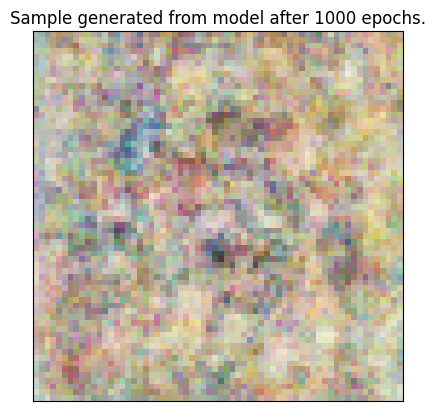

In [ ]:
batch_generated_images = gan_wikiart_generator_64x64_1000e_ukiyoe(batch_size)

image = batch_generated_images[8].permute(1, 2, 0) # Move channel last
image = image.detach().cpu().numpy()    # To Numpy
image = (image + 1) / 2        # Rescale from [-1, 1] to [0, 1]

plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.title(f'Sample generated from model after 1000 epochs.')